<a href="https://colab.research.google.com/github/Nganle21/Amazon_Waffeleisen/blob/main/MA_ATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m spacy download en_core_web_lg
!pip install category_encoders
!pip install sklearn_crfsuite
!pip install -U 'scikit-learn<0.24'
!pip install tensorflow-addons
!pip install transformers
#!pip install --upgrade tensorflow==2.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 15 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
from numpy import sqrt, argmax
import os
import re
import spacy
import scipy
from tqdm import tqdm
import seaborn as sns
nlp = spacy.load('en_core_web_lg')
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.util import ngrams
n_gram = 1
kfold=10
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, f1_score, recall_score, precision_score, plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import CalibratedClassifierCV


import matplotlib.pyplot as plt 
import itertools
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import WhitespaceTokenizer
import category_encoders as ce

import tensorflow as tf
from tensorflow.keras.utils import pad_sequences, to_categorical
from tensorflow.keras.layers import Input, GRU, SimpleRNN
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import sequence
from keras.models import load_model
from tensorflow import keras

import keras as k
import keras.backend as K

import transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
spacy.explain('aux')

'auxiliary'

In [ ]:
print(tf.__version__)

2.9.2


# Split Train Test

Step 1: Split train, test from the original

Step 2: create FE train and FE test

Step 3: Use Jedox to create the first train / test from the absa_train and absa_test

Step 4: Use Jedox to map fe_train / fe_test with flag from train / test --> create train_final and test_final

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/admin.xlsx",engine="openpyxl")
#df.head()
train, test = train_test_split(df, test_size=0.3, random_state = 29)
#train.to_excel("/content/drive/MyDrive/Colab Notebooks/absa_train.xlsx")
#test.to_excel("/content/drive/MyDrive/Colab Notebooks/absa_test.xlsx")

#Feature Selection

No need to be run again

Reset index

In [ ]:
train = train.reset_index().drop(columns=['index'])
test = test.reset_index().drop(columns=['index'])

NameError: ignored

In [ ]:
test.head()

Train DataSet

In [ ]:
fe_train = pd.DataFrame(columns=['id','text', 'token', 'index_s','index_e','lemma', 'pos_', 'tag_', 'dep_', 'shape_', 'is_alpha', 'is_stop'])
for x in tqdm(range(len(train['text']))):
    if len(str(train['text'][x])) != 0:
        lines = str(train['text'][x]).split('#')    
        for line in lines:
                doc = nlp(line)

                for token in doc:
                    fe_train = fe_train.append({'id':train['id'][x],
                                    'text': train['text'][x],
                                    'token': token.text,
                                    'lemma': token.lemma_,
                                    'index_s':token.idx,
                                    'index_e':token.idx + len(token.text),
                                    'pos_': token.pos_,
                                    'tag_': token.tag_,
                                    'dep_': token.dep_,
                                    'shape_': token.shape_,
                                    'is_alpha': token.is_alpha,
                                    'is_stop': token.is_stop}, ignore_index=True)
fe_train = fe_train.drop(fe_train[fe_train.pos_ == 'SPACE'].index)
fe_train = fe_train.drop(fe_train[fe_train.pos_ == 'PUNCT'].index)
fe_train

Test DataSet

In [ ]:
fe_test = pd.DataFrame(columns=['id','text','token', 'index_s','index_e','lemma', 'pos_', 'tag_', 'dep_', 'shape_', 'is_alpha', 'is_stop'])
for x in tqdm(range(len(test['text']))):
    if len(str(test['text'][x])) != 0:
        lines = str(test['text'][x]).split('#')    
        for line in lines:
                doc = nlp(line)

                for token in doc:
                    fe_test = fe_test.append({'id':test['id'][x],
                                    'text': test['text'][x],
                                    'token': token.text,
                                    'lemma': token.lemma_,
                                    'index_s':token.idx,
                                    'index_e':token.idx + len(token.text),
                                    'pos_': token.pos_,
                                    'tag_': token.tag_,
                                    'dep_': token.dep_,
                                    'shape_': token.shape_,
                                    'is_alpha': token.is_alpha,
                                    'is_stop': token.is_stop}, ignore_index=True)
         

fe_test = fe_test.drop(fe_test[fe_test.pos_ == 'SPACE'].index)
fe_test = fe_test.drop(fe_test[fe_test.pos_ == 'PUNCT'].index)
fe_test

In [ ]:
#fe_train.to_csv("/content/drive/MyDrive/Colab Notebooks/fe_train.csv",index=False)
#fe_test.to_csv("/content/drive/MyDrive/Colab Notebooks/fe_test.csv",index=False)

In [ ]:
fe_train=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fe_train.csv")
fe_test=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fe_test.csv")


In [ ]:
fe_test



# Data Preprocessing

In [3]:
train = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/train_final.xlsx",engine="openpyxl")
test = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/test_final.xlsx",engine="openpyxl")

/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


##Data Exploration

In [24]:
train

,id,text,token,index_s,index_e,lemma,pos_,tag_,dep_,shape_,is_alpha,is_stop,sp,flag
0,142122,Made waffles to the recipe included (although ...,Made,0,4,make,VERB,VBN,advcl,Xxxx,True,True,none,0.0
1,142122,Made waffles to the recipe included (although ...,waffles,5,12,waffle,NOUN,NNS,dobj,xxxx,True,False,positive,1.0
2,142122,Made waffles to the recipe included (although ...,to,13,15,to,ADP,IN,prep,xx,True,True,none,0.0
3,142122,Made waffles to the recipe included (although ...,the,16,19,the,DET,DT,det,xxx,True,True,none,0.0
4,142122,Made waffles to the recipe included (although ...,recipe,20,26,recipe,NOUN,NN,pobj,xxxx,True,False,positive,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14554,142782,Four stars because the initial smell took some...,to,60,62,to,PART,TO,prep,xx,True,True,none,0.0
14555,142782,Four stars because the initial smell took some...,Now,64,67,now,ADV,RB,advmod,Xxx,True,True,none,0.0
14556,142782,Four stars because the initial smell took some...,it,68,70,it,PRON,PRP,nsubj,xx,True,True,none,0.0
14557,142782,Four stars because the initial smell took some...,is,71,73,be,AUX,VBZ,ROOT,xx,True,True,none,0.0


In [25]:
t = pd.concat([train,test])

In [26]:
a = t['flag'].value_counts()/t.shape[0]
b = train['flag'].value_counts()/train.shape[0]
c = test['flag'].value_counts()/test.shape[0]

In [27]:
a = pd.DataFrame(a)
a = a.T
b = pd.DataFrame(b)
b = b.T
c = pd.DataFrame(c)
c = c.T

In [28]:
f = pd.concat([a,b,c])
f

,0.0,1.0
flag,0.926242,0.073758
flag,0.925338,0.074662
flag,0.928264,0.071736


In [29]:
dataset = ['total','train','test']
f['dataset'] = dataset
f = f.reset_index().drop(columns=['index'])
f
data = f

In [30]:
data

,0.0,1.0,dataset
0,0.926242,0.073758,total
1,0.925338,0.074662,train
2,0.928264,0.071736,test


In [31]:
import plotly.express as px
import pandas as pd
import plotly.graph_objs as go

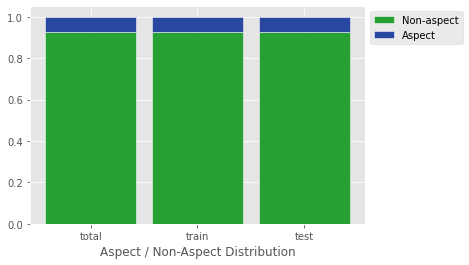

In [32]:
barWidth = 0.85
names = ('total','train','test')
# Create green Bars
plt.bar(dataset, data[0.0].tolist(), color='#27a133', edgecolor='white', width=barWidth,label="Non-aspect")

# Create blue Bars
plt.bar(dataset, data[1.0].tolist(), bottom=[i for i in data[0.0]], color='#2747a1', edgecolor='white', width=barWidth,label="Aspect")
 
# Custom x axis
plt.xticks(dataset, names)
plt.xlabel("Aspect / Non-Aspect Distribution")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
# Show graphic
plt.show()

In [33]:
for i in data[0.0]:
  print(i)

0.9262423465755375
0.9253382787279346
0.9282642089093702


In [34]:
fig = go.Figure()
fig.add_trace(go.Bar(
    y=data[0.0],
    x=data.dataset,
    name="Non-aspect",
    marker=dict(
        color='rgba(0,128,0, 0.6)',
        line=dict(color='rgba(0,128,0, 0.5)', width=0.05)
    )
))
fig.add_trace(go.Bar(
    y=data[1.0],
    x=data.dataset,
    name="Aspect",
    marker=dict(
        color='rgba(0,0,255, 0.6)',
        line=dict(color='rgba(0,0,255, 0.5)', width=0.05)
    )
))
fig.update_layout(
        yaxis=dict(
        title_text="%",
        ticktext=["0%", "20%", "40%", "60%","80%","100%"],
        tickvals=[0, 20, 40, 60, 80, 100],
        tickmode="array",
        titlefont=dict(size=15),
    ),
    autosize=False,
    width=1000,
    height=400,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    title={
        'text': "Aspect / Non-Aspect Distribution",
        'y':0.96,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    barmode='stack')
fig.show()

In [35]:
train['flag'].value_counts()/train.shape[0]

0.0    0.925338
1.0    0.074662
Name: flag, dtype: float64

In [36]:
w = {0:7.5, 1:92.5}

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14559 entries, 0 to 14558
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        14559 non-null  int64  
 1   text      14559 non-null  object 
 2   token     14559 non-null  object 
 3   index_s   14559 non-null  int64  
 4   index_e   14559 non-null  int64  
 5   lemma     14559 non-null  object 
 6   pos_      14559 non-null  object 
 7   tag_      14559 non-null  object 
 8   dep_      14559 non-null  object 
 9   shape_    14559 non-null  object 
 10  is_alpha  14559 non-null  bool   
 11  is_stop   14559 non-null  bool   
 12  sp        14559 non-null  object 
 13  flag      14559 non-null  float64
dtypes: bool(2), float64(1), int64(3), object(8)
memory usage: 1.4+ MB


In [38]:
# find categorical variables

categorical = [var for var in train.columns if train[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :', categorical)

There are 8 categorical variables

The categorical variables are : ['text', 'token', 'lemma', 'pos_', 'tag_', 'dep_', 'shape_', 'sp']


In [39]:
train[categorical].head()

,text,token,lemma,pos_,tag_,dep_,shape_,sp
0,Made waffles to the recipe included (although ...,Made,make,VERB,VBN,advcl,Xxxx,none
1,Made waffles to the recipe included (although ...,waffles,waffle,NOUN,NNS,dobj,xxxx,positive
2,Made waffles to the recipe included (although ...,to,to,ADP,IN,prep,xx,none
3,Made waffles to the recipe included (although ...,the,the,DET,DT,det,xxx,none
4,Made waffles to the recipe included (although ...,recipe,recipe,NOUN,NN,pobj,xxxx,positive


In [40]:
train[categorical].isnull().sum()

text      0
token     0
lemma     0
pos_      0
tag_      0
dep_      0
shape_    0
sp        0
dtype: int64

In [41]:
# print categorical variables containing missing values

cat1 = [var for var in categorical if train[var].isnull().sum()!=0]

print(train[cat1].isnull().sum())

Series([], dtype: float64)


In [42]:
# view frequency of categorical variables

for var in categorical: 
    
    print(train[var].value_counts())

"Zero pointed. The low price was an indicator of the poor quality but there it is surreal! Either I have been unlucky, or it's just to take consumption for morons! As soon as it came out of the box (which was perfectly intact!), A rubber rivet stands out. Due to the low utility of the element, I did not pay attention to it! Then it is the plastic part allowing to lock the closure that has dropped out of the grip. Same reaction. I said to myself ""it doesn't prevent me from using it and it's easy to put back"". But then in full cleaning (after having left food oil to take off the ends of the remaining dough), I 'Open the waffle iron and a game literally begins to break into several pieces. Plastic parts have come out. And after meticulous examination, the object carried a micro trace of brokenness, which was enough to weaken several elements of the structure. So scam on the whole line because it was the first time use and that I cannot send it back as it is! Without comments"    191
Is 

In [43]:
# check for cardinality in categorical variables

for var in categorical:
    
    print(var, ' contains ', len(train[var].unique()), ' labels')

text  contains  504  labels
token  contains  2216  labels
lemma  contains  1638  labels
pos_  contains  16  labels
tag_  contains  38  labels
dep_  contains  43  labels
shape_  contains  69  labels
sp  contains  4  labels


Declare feature vector and target variable

In [44]:
X_train = train.drop(columns=['id','text','token','sp','flag'],axis=1)
X_test = test.drop(columns=['id','text','token','sp','flag'],axis=1)
y_train = train['flag']
y_test = test['flag']

In [45]:
X_train_crf = train.drop(columns=['text','token','sp'],axis=1)
X_test_crf = test.drop(columns=['text','token','sp'],axis=1)
y_train_crf = train['flag']
y_test_crf = test['flag']

In [46]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14559, 9), (14559,), (6510, 9), (6510,))

##Feature Engineering

### Label Encoding

In [47]:
X_train.head()

,index_s,index_e,lemma,pos_,tag_,dep_,shape_,is_alpha,is_stop
0,0,4,make,VERB,VBN,advcl,Xxxx,True,True
1,5,12,waffle,NOUN,NNS,dobj,xxxx,True,False
2,13,15,to,ADP,IN,prep,xx,True,True
3,16,19,the,DET,DT,det,xxx,True,True
4,20,26,recipe,NOUN,NN,pobj,xxxx,True,False


In [48]:
X = pd.concat([X_train,X_test])
X.shape

(21069, 9)

In [49]:
# Label Encoder
le = preprocessing.LabelEncoder()

#label_encoded_df = df.copy()
for col in X.columns:
    X[col]=le.fit_transform(X[col])


In [50]:
X_train = X.head(X_train.shape[0])
X_test = X.tail(X_test.shape[0])

In [51]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14559, 9), (14559,), (6510, 9), (6510,))

In [52]:
X_test


,index_s,index_e,lemma,pos_,tag_,dep_,shape_,is_alpha,is_stop
0,0,4,1098,14,33,0,27,1,0
1,6,8,1740,5,4,19,55,1,1
2,10,15,850,7,16,27,58,1,0
3,17,25,1295,2,21,4,58,1,0
4,28,31,906,14,28,0,26,1,0
...,...,...,...,...,...,...,...,...,...
6505,24,30,1390,7,13,7,58,1,0
6506,32,34,793,1,7,37,55,1,1
6507,36,39,1909,10,35,27,58,1,1
6508,41,44,1964,10,20,27,58,1,1


### Feature Scaling

In [53]:
cols = X_train.columns

In [54]:
X_train.describe()

,index_s,index_e,lemma,pos_,tag_,dep_,shape_,is_alpha,is_stop
count,14559.000000,14559.000000,14559.000000,14559.000000,14559.000000,14559.000000,14559.000000,14559.000000,14559.000000
mean,132.949035,136.162305,1058.412322,6.223367,16.080569,17.066351,52.147675,0.974724,0.552717
std,136.684886,136.542292,599.639136,4.484940,9.630338,12.308503,11.423327,0.156969,0.497230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.000000,41.000000,462.500000,2.000000,8.000000,6.000000,53.000000,1.000000,0.000000
50%,90.000000,93.000000,1075.000000,7.000000,13.000000,15.000000,55.000000,1.000000,1.000000
75%,180.000000,183.000000,1729.500000,10.000000,21.000000,27.000000,58.000000,1.000000,1.000000
max,871.000000,875.000000,1974.000000,15.000000,37.000000,42.000000,74.000000,1.000000,1.000000


In [55]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
X_train = pd.DataFrame(X_train,columns=[cols])
X_test = pd.DataFrame(X_test,columns=[cols])


In [57]:
X_train.describe()

,index_s,index_e,lemma,pos_,tag_,dep_,shape_,is_alpha,is_stop
count,14559.000000,14559.000000,14559.000000,14559.000000,14559.000000,14559.000000,14559.000000,14559.000000,14559.000000
mean,0.152640,0.155614,0.536176,0.414891,0.434610,0.406342,0.704698,0.974724,0.552717
std,0.156929,0.156048,0.303769,0.298996,0.260279,0.293060,0.154369,0.156969,0.497230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.042480,0.046857,0.234296,0.133333,0.216216,0.142857,0.716216,1.000000,0.000000
50%,0.103330,0.106286,0.544580,0.466667,0.351351,0.357143,0.743243,1.000000,1.000000
75%,0.206659,0.209143,0.876140,0.666667,0.567568,0.642857,0.783784,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
sum(y_test)

467.0

# ATE

## Pattern-based

In [ ]:
train_pbm = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/train.xlsx",engine="openpyxl")
test_pbm = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/test.xlsx",engine="openpyxl")

/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning:

Workbook contains no default style, apply openpyxl's default



In [ ]:
df = (pd.concat([train_pbm, test_pbm]).reset_index()).drop(columns=['index'])
#df = df.loc[df['flag'] == 1.0]
df.shape

(1555, 6)

In [ ]:
df.head()

,id,text,aspectTerm,From,To,SP
0,142087,I am very satisfied with it ... I have used th...,price,82,87,positive
1,142089,"Cheap processing, wobbling unstable unstable l...",processing,6,16,negative
2,142089,"Cheap processing, wobbling unstable unstable l...",lids,45,49,negative
3,142089,"Cheap processing, wobbling unstable unstable l...",baking time,142,153,negative
4,142091,"The iron does not remain, the waffles are too ...",waffles,30,37,negative


In [ ]:
df_token = pd.concat([train,test],ignore_index=True)
#df_token = df_token[['id','text','token','flag']]
#df_token = pd.merge(df, df_token, on=['id'])


In [ ]:
df_token.head()

,id,text,token,index_s,index_e,lemma,pos_,tag_,dep_,shape_,is_alpha,is_stop,sp,flag
0,142122,Made waffles to the recipe included (although ...,Made,0,4,make,VERB,VBN,advcl,Xxxx,True,True,none,0.0
1,142122,Made waffles to the recipe included (although ...,waffles,5,12,waffle,NOUN,NNS,dobj,xxxx,True,False,positive,1.0
2,142122,Made waffles to the recipe included (although ...,to,13,15,to,ADP,IN,prep,xx,True,True,none,0.0
3,142122,Made waffles to the recipe included (although ...,the,16,19,the,DET,DT,det,xxx,True,True,none,0.0
4,142122,Made waffles to the recipe included (although ...,recipe,20,26,recipe,NOUN,NN,pobj,xxxx,True,False,positive,1.0


In [ ]:
df=df_token

### Manual Rule-based

In [ ]:
aspect_terms = []
comp_terms = []

for x in tqdm(range(len(df['text']))):
    amod_pairs = []
    advmod_pairs = []
    compound_pairs = []
    xcomp_pairs = []
    neg_pairs = []
    
    if len(str(df['text'][x])) != 0:
        lines = str(df['text'][x]).replace('*',' ').replace('-',' ').replace('so ',' ').replace('be ',' ').replace('are ',' ').replace('just ',' ').replace('get ','').replace('were ',' ').replace('When ','').replace('when ','').replace('again ',' ').replace('where ','').replace('how ',' ').replace('has ',' ').replace('Here ',' ').replace('here ',' ').replace('now ',' ').replace('see ',' ').replace('why ',' ').split('.')    
        for line in lines:
                doc = nlp(line)
                str1=''
                str2=''
                for token in doc:
                    if token.pos_ is 'NOUN':
                        for j in token.lefts:
                            if j.dep_ == 'compound':
                                compound_pairs.append((j.text+' '+token.text,token.text))
                            if j.dep_ is 'amod' and j.pos_ is 'ADJ': #primary condition
                                str1 = j.text+' '+token.text
                                amod_pairs.append(j.text+' '+token.text)
                                for k in j.lefts:
                                    if k.dep_ is 'advmod': #secondary condition to get adjective of adjectives
                                        str2 = k.text+' '+j.text+' '+token.text
                                        amod_pairs.append(k.text+' '+j.text+' '+token.text)
                                mtch = re.search(re.escape(str1),re.escape(str2))
                                if mtch is not None:
                                    amod_pairs.remove(str1)
                    if token.pos_ is 'VERB':
                        for j in token.lefts:
                            if j.dep_ is 'advmod' and j.pos_ is 'ADV':
                                advmod_pairs.append(j.text+' '+token.text)
                            if j.dep_ is 'neg' and j.pos_ is 'ADV':
                                neg_pairs.append(j.text+' '+token.text)
                        for j in token.rights:
                            if j.dep_ is 'advmod'and j.pos_ is 'ADV':
                                advmod_pairs.append(token.text+' '+j.text)
                    if token.pos_ is 'ADJ':
                        for j,h in zip(token.rights,token.lefts):
                            if j.dep_ is 'xcomp' and h.dep_ is not 'neg':
                                for k in j.lefts:
                                    if k.dep_ is 'aux':
                                        xcomp_pairs.append(token.text+' '+k.text+' '+j.text)
                            elif j.dep_ is 'xcomp' and h.dep_ is 'neg':
                                if k.dep_ is 'aux':
                                        neg_pairs.append(h.text +' '+token.text+' '+k.text+' '+j.text)
        pairs = list(set(amod_pairs+advmod_pairs+neg_pairs+xcomp_pairs))
        for i in range(len(pairs)):
            if len(compound_pairs)!=0:
                for comp in compound_pairs:
                    mtch = re.search(re.escape(comp[1]),re.escape(pairs[i]))
                    if mtch is not None:
                        pairs[i] = pairs[i].replace(mtch.group(),comp[0])
    aspect_terms.append(pairs)
    comp_terms.append(compound_pairs)

df['compound_nouns'] = comp_terms
df['aspect_keywords'] = aspect_terms
df.head()

<>:18: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:22: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:22: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:26: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:32: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:34: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:34: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:36: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:36: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:39: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:39: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:41: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:43: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:43: SyntaxWarning:

"is not" with a literal. Did you mean "!="?

<>:45: SyntaxWarning:

"is" with a literal. Did you mean "=="?

<>:47: SyntaxWarning:

"is" with a l

,id,text,token,index_s,index_e,lemma,pos_,tag_,dep_,shape_,is_alpha,is_stop,sp,flag,compound_nouns,aspect_keywords
0,142122,Made waffles to the recipe included (although ...,Made,0,4,make,VERB,VBN,advcl,Xxxx,True,True,none,0.0,[],"[decent amount, only need]"
1,142122,Made waffles to the recipe included (although ...,waffles,5,12,waffle,NOUN,NNS,dobj,xxxx,True,False,positive,1.0,[],"[decent amount, only need]"
2,142122,Made waffles to the recipe included (although ...,to,13,15,to,ADP,IN,prep,xx,True,True,none,0.0,[],"[decent amount, only need]"
3,142122,Made waffles to the recipe included (although ...,the,16,19,the,DET,DT,det,xxx,True,True,none,0.0,[],"[decent amount, only need]"
4,142122,Made waffles to the recipe included (although ...,recipe,20,26,recipe,NOUN,NN,pobj,xxxx,True,False,positive,1.0,[],"[decent amount, only need]"


In [ ]:
df['asp']=df['aspect_keywords'].apply(' '.join)

In [ ]:
for i in range(len(df)):
  #df['pred'] = np.where(df['token'] in df['asp'], 1.0, 0.0)
  df['pred'][i] = np.where(df['token'][i] in df['asp'][i], 1.0, 0.0)
  #df['flag_p'][i] = np.where(df['token'][i] in df['asp'][i], 1, 0)

<ipython-input-539-871c8698914f>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df.tail(50)

,id,text,token,index_s,index_e,lemma,pos_,tag_,dep_,shape_,is_alpha,is_stop,sp,flag,compound_nouns,aspect_keywords,asp,test,flag_pred,pred
21019,142885,totally useless the non stick surface is defia...,the,204,207,the,DET,DT,det,xxx,True,True,none,0.0,"[(non stick, stick), (stick surface, surface),...","[defiantly non stick, pure junk, happy bunny, ...",defiantly non stick pure junk happy bunny dump...,False,False,0
21020,142885,totally useless the non stick surface is defia...,bin,208,211,bin,NOUN,NN,pobj,xxx,True,False,none,0.0,"[(non stick, stick), (stick surface, surface),...","[defiantly non stick, pure junk, happy bunny, ...",defiantly non stick pure junk happy bunny dump...,False,False,0
21021,142885,totally useless the non stick surface is defia...,not,212,215,not,PART,RB,neg,xxx,True,True,none,0.0,"[(non stick, stick), (stick surface, surface),...","[defiantly non stick, pure junk, happy bunny, ...",defiantly non stick pure junk happy bunny dump...,False,False,0
21022,142885,totally useless the non stick surface is defia...,a,216,217,a,DET,DT,det,x,True,True,none,0.0,"[(non stick, stick), (stick surface, surface),...","[defiantly non stick, pure junk, happy bunny, ...",defiantly non stick pure junk happy bunny dump...,True,False,1
21023,142885,totally useless the non stick surface is defia...,happy,218,223,happy,ADJ,JJ,amod,xxxx,True,False,none,0.0,"[(non stick, stick), (stick surface, surface),...","[defiantly non stick, pure junk, happy bunny, ...",defiantly non stick pure junk happy bunny dump...,True,False,1
21024,142885,totally useless the non stick surface is defia...,bunny,224,229,bunny,NOUN,NN,dobj,xxxx,True,False,none,0.0,"[(non stick, stick), (stick surface, surface),...","[defiantly non stick, pure junk, happy bunny, ...",defiantly non stick pure junk happy bunny dump...,True,False,1
21025,142885,totally useless the non stick surface is defia...,usually,230,237,usually,ADV,RB,advmod,xxxx,True,False,none,0.0,"[(non stick, stick), (stick surface, surface),...","[defiantly non stick, pure junk, happy bunny, ...",defiantly non stick pure junk happy bunny dump...,True,False,1
21026,142885,totally useless the non stick surface is defia...,my,238,240,my,PRON,PRP$,poss,xx,True,True,none,0.0,"[(non stick, stick), (stick surface, surface),...","[defiantly non stick, pure junk, happy bunny, ...",defiantly non stick pure junk happy bunny dump...,False,False,0
21027,142885,totally useless the non stick surface is defia...,purchases,241,250,purchase,NOUN,NNS,nsubj,xxxx,True,False,none,0.0,"[(non stick, stick), (stick surface, surface),...","[defiantly non stick, pure junk, happy bunny, ...",defiantly non stick pure junk happy bunny dump...,False,False,0
21028,142885,totally useless the non stick surface is defia...,from,251,255,from,ADP,IN,prep,xxxx,True,True,none,0.0,"[(non stick, stick), (stick surface, surface),...","[defiantly non stick, pure junk, happy bunny, ...",defiantly non stick pure junk happy bunny dump...,False,False,0


In [ ]:
print(classification_report(df['flag'],df['pred']))

              precision    recall  f1-score   support

         0.0       0.94      0.76      0.84     19515
         1.0       0.11      0.39      0.18      1554

    accuracy                           0.73     21069
   macro avg       0.53      0.57      0.51     21069
weighted avg       0.88      0.73      0.79     21069



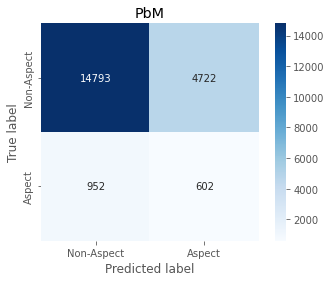

In [ ]:
cm = confusion_matrix(df['flag'], df['pred'])

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('PbM')
plt.show()

# ML


## Logistic Regression

In [ ]:
w

{0: 7.5, 1: 92.5}

Creating a dictionary with the hyperparameters

In [ ]:
# parameter grid
params = {
    'max_iter': [100,200,300],
    'penalty' : ['l1','l2','elastic','None'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear','saga','sag'],
    'verbose' : [1]
}

In [ ]:
lr=LogisticRegression(random_state=29, class_weight = w)
lr_rs=RandomizedSearchCV(lr, params, cv=10, random_state = 29, scoring='f1_macro')
lr_rs.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.




[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:976: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet

max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueE

max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds
[LibLinear]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueE

RandomizedSearchCV(cv=10,
                   estimator=LogisticRegression(class_weight={0: 7.5, 1: 92.5},
                                                random_state=29),
                   param_distributions={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l1', 'l2', 'elastic',
                                                    'None'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'saga', 'sag'],
                                        'verbose': [1]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",lr_rs.best_params_)
print("f1_macro :",lr_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'verbose': 1, 'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 100, 'C': 10.0}
f1_macro : 0.6135117571205936


In [ ]:
predict_result_aspect = lr_rs.predict(X_test)

In [ ]:
sum(predict_result_aspect)

1894.0

In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))



accuracy
0.7663594470046083
f1 score
0.8213265924976914
recall
0.7663594470046083
precision
0.9347202652455486


In [ ]:
print(classification_report(y_test,predict_result_aspect))

              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      6043
         1.0       0.22      0.90      0.36       467

    accuracy                           0.77      6510
   macro avg       0.61      0.83      0.61      6510
weighted avg       0.93      0.77      0.82      6510



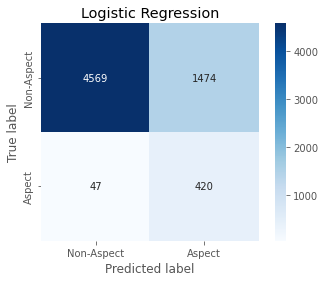

In [ ]:
cm = confusion_matrix(y_test,predict_result_aspect)

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Logistic Regression')
plt.show()

Best Threshold=0.599661, G-Mean=0.8277


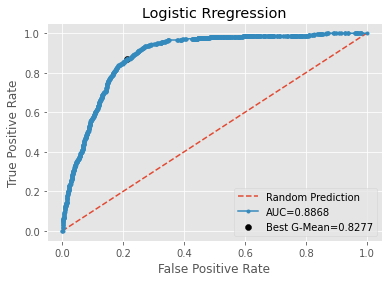

In [ ]:
from numpy import sqrt, argmax
probas_ = lr_rs.predict_proba(X_test)
probas_ = probas_[:,1]

fpr, tpr, thresholds = roc_curve(y_test,  probas_)
auc = roc_auc_score(y_test, probas_)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.4f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random Prediction')
plt.plot(fpr, tpr, marker='.', label="AUC="+str(np.round(auc,4)))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best G-Mean='+str(np.round(gmeans[ix],4)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("Logistic Rregression")
# show the plot
plt.show()

## Random Forest

In [ ]:
# parameter grid
params= {'n_estimators': [100,200,300],
               'max_features': ['auto', 'log2','int','float'],
               'max_depth': np.arange(2,5,1),
               'min_samples_split': np.arange(2,5,1),
               'min_samples_leaf': np.arange(1,4,1),
               'bootstrap': [True, False],
                'verbose':[1]}

In [ ]:
rf = RandomForestClassifier(random_state=29, class_weight = w)
rf_rs=RandomizedSearchCV(rf, params, cv=10, random_state = 29,scoring='f1_macro')
rf_rs.fit(X_train,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 819, in _dispat

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(class_weight={0: 7.5,
                                                                  1: 92.5},
                                                    random_state=29),
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': array([2, 3, 4]),
                                        'max_features': ['auto', 'log2', 'int',
                                                         'float'],
                                        'min_samples_leaf': array([1, 2, 3]),
                                        'min_samples_split': array([2, 3, 4]),
                                        'n_estimators': [100, 200, 300],
                                        'verbose': [1]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",rf_rs.best_params_)
print("f1_macro :",rf_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'verbose': 1, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3, 'bootstrap': False}
f1_macro : 0.6096047505517725


In [ ]:
predict_result_aspect = rf_rs.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))


accuracy
0.754531490015361
f1 score
0.8128733068715019
recall
0.754531490015361
precision
0.9352678475930861


In [ ]:
print(classification_report(y_test,predict_result_aspect))

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      6043
         1.0       0.21      0.91      0.35       467

    accuracy                           0.75      6510
   macro avg       0.60      0.83      0.60      6510
weighted avg       0.94      0.75      0.81      6510



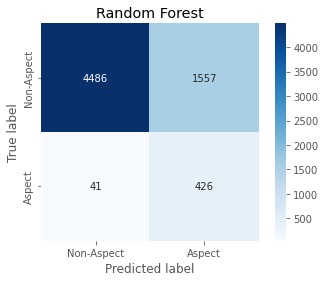

In [ ]:
cm = confusion_matrix(y_test,predict_result_aspect)

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Random Forest')
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.1s finished


Best Threshold=0.696632, G-Mean=0.8384


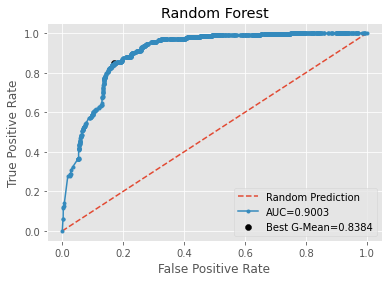

In [ ]:
from numpy import sqrt, argmax

probas_ = rf_rs.predict_proba(X_test)
probas_ = probas_[:,1]


fpr, tpr, thresholds = roc_curve(y_test,  probas_)
auc = roc_auc_score(y_test, probas_)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.4f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random Prediction')
plt.plot(fpr, tpr, marker='.', label="AUC="+str(np.round(auc,4)))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best G-Mean='+str(np.round(gmeans[ix],4)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("Random Forest")
# show the plot
plt.show()

## Multinomial NB 

In [ ]:
# parameter grid
params = {
  'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
  'fit_prior': [True, False]
}

In [ ]:
mnb = MultinomialNB()
mnb_rs=RandomizedSearchCV(mnb, params, cv=10, random_state = 29,scoring='f1_macro')
mnb_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=MultinomialNB(),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100, 1000],
                                        'fit_prior': [True, False]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",mnb_rs.best_params_)
print("f1_macro :",mnb_rs.best_score_)

tuned hpyerparameters :(best parameters)  {'fit_prior': False, 'alpha': 1000}
f1_macro : 0.5432453735916596


In [ ]:
predict_result_aspect = mnb_rs.predict(X_test)

In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))


accuracy
0.743778801843318
f1 score
0.8006425764519427
recall
0.743778801843318
precision
0.885929262182346


In [ ]:
print(classification_report(y_test,predict_result_aspect))

              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85      6043
         1.0       0.12      0.42      0.19       467

    accuracy                           0.74      6510
   macro avg       0.53      0.59      0.52      6510
weighted avg       0.89      0.74      0.80      6510



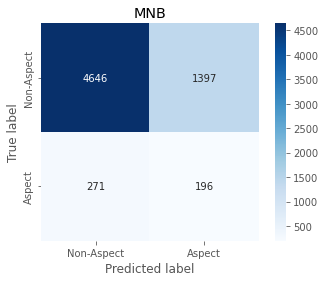

In [ ]:
cm = confusion_matrix(y_test,predict_result_aspect)

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('MNB')
plt.show()

Best Threshold=0.456048, G-Mean=0.7456


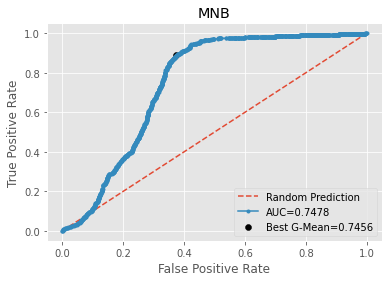

In [ ]:
from numpy import sqrt, argmax

probas_ = mnb_rs.predict_proba(X_test)
probas_ = probas_[:,1]

fpr, tpr, thresholds = roc_curve(y_test,  probas_)
auc = roc_auc_score(y_test, probas_)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.4f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random Prediction')
plt.plot(fpr, tpr, marker='.', label="AUC="+str(np.round(auc,4)))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best G-Mean='+str(np.round(gmeans[ix],4)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("MNB")
# show the plot
plt.show()

## SVM

In [ ]:
params = {
    "loss" : ["hinge"],#, "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "elasticnet","none"],
    'verbose' :[1]
}

In [ ]:
#dont run again
svm = SGDClassifier(random_state=29, class_weight = w)
svm_rs=RandomizedSearchCV(svm, params, cv=10, random_state = 29,scoring='f1_macro')
svm_rs.fit(X_train, y_train)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Total training time: 0.03 seconds.
-- Epoch 12
Norm: 16.22, NNZs: 9, Bias: -5.568110, T: 157236, Avg. loss: 0.682578
Total training time: 0.04 seconds.
-- Epoch 13
Norm: 15.69, NNZs: 9, Bias: -5.083699, T: 170339, Avg. loss: 0.676323
Total training time: 0.04 seconds.
-- Epoch 14
Norm: 15.31, NNZs: 9, Bias: -4.912259, T: 183442, Avg. loss: 0.636422
Total training time: 0.04 seconds.
-- Epoch 15
Norm: 14.78, NNZs: 9, Bias: -3.439276, T: 196545, Avg. loss: 0.630238
Total training time: 0.05 seconds.
-- Epoch 16
Norm: 14.35, NNZs: 8, Bias: -4.425810, T: 209648, Avg. loss: 0.631379
Total training time: 0.05 seconds.
-- Epoch 17
Norm: 13.97, NNZs: 9, Bias: -4.112479, T: 222751, Avg. loss: 0.633268
Total training time: 0.05 seconds.
-- Epoch 18
Norm: 13.75, NNZs: 9, Bias: -4.239841, T: 235854, Avg. loss: 0.614505
Total training time: 0.06 seconds.
-- Epoch 19
Norm: 13.69, NNZs: 8, Bias: -4.070180, T: 248957, Avg. loss: 0.611827
Total t

RandomizedSearchCV(cv=10,
                   estimator=SGDClassifier(class_weight={0: 7.5, 1: 92.5},
                                           random_state=29),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1],
                                        'loss': ['hinge'],
                                        'penalty': ['l2', 'l1', 'elasticnet',
                                                    'none'],
                                        'verbose': [1]},
                   random_state=29, scoring='f1_macro')

In [ ]:
print("tuned hpyerparameters :(best parameters) ",svm_rs.best_params_)
print("f1_macro :",svm_rs.best_score_)


tuned hpyerparameters :(best parameters)  {'verbose': 1, 'penalty': 'none', 'loss': 'hinge', 'alpha': 0.01}
f1_macro : 0.6127407480066014


In [ ]:
predict_result_aspect = svm_rs.predict(X_test)

In [ ]:
print('accuracy')
print(accuracy_score(y_test, predict_result_aspect))
print('f1 score')
print(f1_score(y_test, predict_result_aspect,average='weighted'))
print('recall')
print(recall_score(y_test, predict_result_aspect,average='weighted'))
print('precision')
print(precision_score(y_test, predict_result_aspect,average='weighted'))


accuracy
0.7536098310291859
f1 score
0.8122282238480115
recall
0.7536098310291859
precision
0.9356549082244324


In [ ]:
print(classification_report(y_test,predict_result_aspect))

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      6043
         1.0       0.21      0.92      0.35       467

    accuracy                           0.75      6510
   macro avg       0.60      0.83      0.60      6510
weighted avg       0.94      0.75      0.81      6510



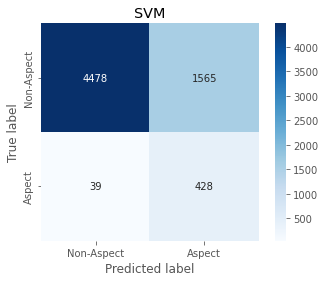

In [ ]:
cm = confusion_matrix(y_test,predict_result_aspect)

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('SVM')
plt.show()

Best Threshold=-0.252113, G-Mean=0.826


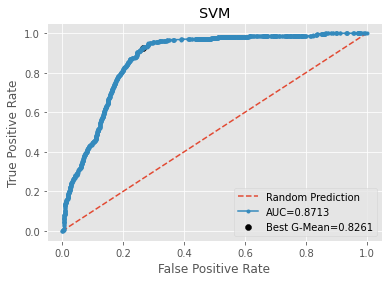

In [ ]:



probas_ = svm_rs.decision_function(X_test)
#probas_ = probas_[:,1]

fpr, tpr, thresholds = roc_curve(y_test,  probas_)
auc = roc_auc_score(y_test, probas_)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random Prediction')
plt.plot(fpr, tpr, marker='.', label="AUC="+str(np.round(auc,4)))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best G-Mean='+str(np.round(gmeans[ix],4)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("SVM")
# show the plot
plt.show()

## CRF

In [ ]:
##import libraries
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [ ]:
#train data
X_train_crf_dict = []
for i in (X_train_crf['id'].unique()):
  dic = X_train_crf[X_train_crf.id == i][['index_s', 'index_e', 'lemma', 'pos_', 'tag_', 'dep_', 'shape_', 'is_alpha', 'is_stop']].to_dict(orient = 'records')
  X_train_crf_dict.append(dic)

X_train_crf["flag"]=X_train_crf["flag"].astype(str)
y_train_crf_dict = []
for i in (X_train_crf['id'].unique()):
  dic = X_train_crf[X_train_crf.id == i]['flag'].tolist()
  y_train_crf_dict.append(dic)


In [ ]:
#test data
X_test_crf_dict = []
for i in (X_test_crf['id'].unique()):
  dic = X_test_crf[X_test_crf.id == i][['index_s', 'index_e', 'lemma', 'pos_', 'tag_', 'dep_', 'shape_', 'is_alpha', 'is_stop']].to_dict(orient = 'records')
  X_test_crf_dict.append(dic)

X_test_crf["flag"]=X_test_crf["flag"].apply(str)
y_test_crf_dict = []
for i in (X_test_crf['id'].unique()):
  dic = X_test_crf[X_test_crf.id == i]['flag'].tolist()
  y_test_crf_dict.append(dic)

In [ ]:

params = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

In [ ]:
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted')

In [ ]:
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    #c1=0.1,
    #c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)


In [ ]:
#dont run again
#crf_rs = RandomizedSearchCV(crf, params,
 #                       cv=10,
  #                      verbose=1,
   #                     n_jobs=-1,
    #                    n_iter=50,
     #                   scoring=f1_scorer) #Fitting 10 folds for each of 50 candidates, totalling 500 fits
#crf_rs.fit(X_train_crf_dict, y_train_crf_dict)

In [ ]:
new_crf = sklearn_crfsuite.CRF(c1=0.6075590045786946, c2=0.003508383508933939, algorithm='lbfgs',max_iterations=100,all_possible_transitions=True)
new_crf.fit(X_train_crf_dict, y_train_crf_dict)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:209: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.6075590045786946,
    c2=0.003508383508933939, keep_tempfiles=None, max_iterations=100)

In [ ]:
#print("tuned hpyerparameters :(best parameters) ",crf_rs.best_params_)
#print("f1_macro :",crf_rs.best_score_)

In [ ]:
predict_result_aspect = new_crf.predict(X_test_crf_dict)

In [ ]:
probas_ = new_crf.predict_marginals(X_test_crf_dict)

In [ ]:
len(probas_)

217

In [ ]:

print(metrics.flat_classification_report(y_test_crf_dict,predict_result_aspect))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      6043
         1.0       0.81      0.66      0.72       467

    accuracy                           0.96      6510
   macro avg       0.89      0.82      0.85      6510
weighted avg       0.96      0.96      0.96      6510



/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass labels=None as keyword args. From version 0.25 passing these as positional arguments will result in an error



In [ ]:
from functools import reduce # Python3
crf_y_test = reduce(lambda x,y :x+y ,y_test_crf_dict)
crf_y_pred = reduce(lambda x,y :x+y ,predict_result_aspect)


In [ ]:
cm = confusion_matrix(crf_y_test, crf_y_pred)

In [ ]:
cm

array([[5969,   74],
       [ 161,  306]])

In [ ]:

(5966+306)/(5966+77+161+306)

0.9634408602150538

In [ ]:
5966+77+161+306

6510

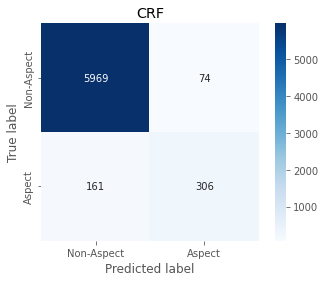

In [ ]:
x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

ax.set_title('CRF')
plt.show()

In [ ]:
a_ = []
for i in (range(len(probas_))):
  for m in (range(len(probas_[i]))):
    a = probas_[i][m]
    a = list(a.values())[1]
    a_.append(a)


Best Threshold=0.126637, G-Mean=0.913


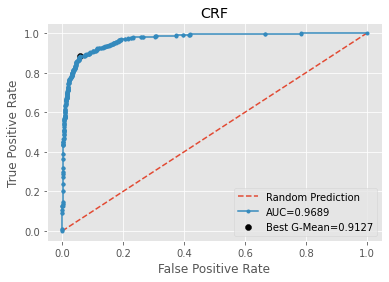

In [ ]:
crf_y_test = list( map(float, crf_y_test))
crf_y_pred = list( map(float, crf_y_pred))


fpr, tpr, thresholds = roc_curve(crf_y_test,  a_)
auc = roc_auc_score(crf_y_test, a_)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random Prediction')
plt.plot(fpr, tpr, marker='.', label="AUC="+str(np.round(auc,4)))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best G-Mean='+str(np.round(gmeans[ix],4)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("CRF")
# show the plot
plt.show()

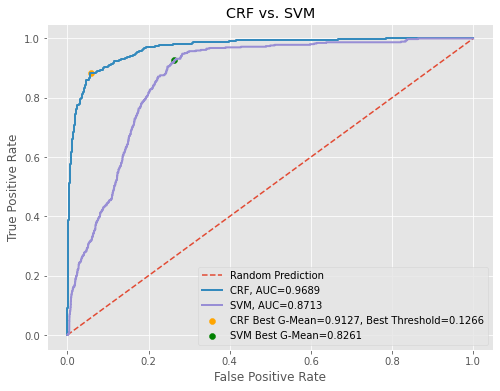

In [ ]:
plt.figure(figsize=(8, 6)).clf()

#crf
crf_y_test = list( map(float, crf_y_test))
crf_y_pred = list( map(float, crf_y_pred))


fpr, tpr, thresholds = roc_curve(crf_y_test,  a_)
auc = roc_auc_score(crf_y_test, a_)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
#print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random Prediction')
plt.plot(fpr, tpr,linewidth=2, label="CRF, AUC="+str(np.round(auc,4)))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='orange', label='CRF Best G-Mean='+str(np.round(gmeans[ix],4))+", Best Threshold="+str(np.round(thresholds[ix],4)))

#svm


probas_ = svm_rs.decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test,  probas_)
auc = roc_auc_score(y_test, probas_)

# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))

# locate the index of the largest g-mean
ix = argmax(gmeans)
#print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
#plt.plot([0,1], [0,1], linestyle='--', label='Random Prediction')
plt.plot(fpr, tpr,linewidth=2, label="SVM, AUC="+str(np.round(auc,4)))
plt.scatter(fpr[ix], tpr[ix], marker='o', color='green', label='SVM Best G-Mean='+str(np.round(gmeans[ix],4)))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title("CRF vs. SVM")
# show the plot
plt.show()

#DL

### DL Preprocessing

In [79]:
df_dl = pd.concat([train,test])
df_dl = df_dl[['id','lemma','flag']]
df_dl.flag = df_dl.flag.astype(int)
dataset = df_dl.rename(columns={"id": "sentence_idx", "lemma": "word","flag":"tag"})

In [80]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [81]:
getter = SentenceGetter(dataset)

In [82]:
sentences = getter.sentences
sentences[1]

[('cheap', 0),
 ('processing', 1),
 ('wobble', 0),
 ('unstable', 0),
 ('unstable', 0),
 ('lid', 1),
 ('which', 0),
 ('be', 0),
 ('fall', 0),
 ('independently', 0),
 ('again', 0),
 ('each', 0),
 ('time', 0),
 ('you', 0),
 ('open', 0),
 ('and', 0),
 ('an', 0),
 ('incredible', 0),
 ('and', 0),
 ('unreasonable', 0),
 ('baking', 1),
 ('time', 0),
 ('give', 0),
 ('the', 0),
 ('occasion', 0),
 ('to', 0),
 ('send', 0),
 ('the', 0),
 ('product', 0),
 ('back', 0)]

In [83]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 207


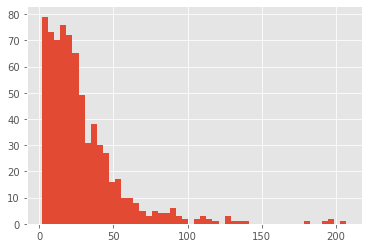

In [84]:
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [85]:
words = list(set(dataset["word"].values))
words.append("ENDPAD")

In [86]:
n_words = len(words)
n_words

1978

In [87]:
tags = []
for tag in set(dataset["tag"].values):

        tags.append(tag)
n_tags = len(tags)
n_tags

2

In [88]:
from future.utils import iteritems
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [89]:
X = [[word2idx[w[0]] for w in s] for s in sentences]

In [90]:
np.array(X).shape

<ipython-input-90-9087bc21783f>:1: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



(722,)

In [91]:
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

In [92]:
y_idx = [[tag2idx[w[1]] for w in s] for s in sentences]
print(sentences[100])
print(y_idx[100])

[('this', 0), ('be', 0), ('a', 0), ('fantastic', 0), ('celebration', 0), ('for', 0), ('my', 0), ('4', 0), ('and', 0), ('3', 0), ('year', 0), ('old', 0), ('grandchild', 0), ('a', 0), ('boy', 0), ('and', 0), ('girl', 0), ('and', 0), ('they', 0), ('love', 0), ('the', 0), ('car', 1), ('and', 0), ('be', 0), ('sooo', 0), ('yummy', 0), ('for', 0), ('they', 0), ('and', 0), ('the', 0), ('adult', 0), ('smile', 0), ('I', 0), ('highly', 0), ('recommend', 0)]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [93]:
y = pad_sequences(maxlen=maxlen, sequences=y_idx, padding="post", value=tag2idx[0])
print(y[100])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [94]:
class_weights = compute_class_weight('balanced', np.unique(y), y.ravel())
class_weights

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:67: FutureWarning:

Pass classes=[0 1], y=[0 0 0 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error



array([ 0.50525355, 48.08687259])

In [95]:
y = [to_categorical(i, num_classes=n_tags, dtype ="int32") for i in y]

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 29)

In [97]:
#class_weights = compute_class_weight('balanced', np.unique(y_train),np.array(y_train).ravel())
#class_weights

In [98]:

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## RNN

### SimpleRNN

Sequence to Sequence w TimeDistributed and return_sequences = True. Good for data like Time Series Data or the data comprising different frames of a Video

In [114]:

input = Input(shape=(maxlen,),dtype="int32")
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
model = SimpleRNN(units=word_embedding_size * 4, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # previously softmax output layer



In [115]:
model_srnn = Model(input,out)
model_srnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 207)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 207, 300)          593400    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 207, 1200)         1801200   
                                                                 
 time_distributed_1 (TimeDis  (None, 207, 2)           2402      
 tributed)                                                       
                                                                 
Total params: 2,397,002
Trainable params: 2,397,002
Non-trainable params: 0
_________________________________________________________________


In [116]:
adam = k.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
model_srnn.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [117]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 10, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [118]:
history = model_srnn.fit(X_train, np.array(y_train), batch_size=256, epochs=100, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.7988 - get_f1: 0.5177
Epoch 1: val_loss improved from inf to 0.44106, saving model to /content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint/
2/2 [==============================] - 4s 2s/step - loss: 0.7988 - get_f1: 0.5177 - val_loss: 0.4411 - val_get_f1: 0.9258
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.7596 - get_f1: 0.5487
Epoch 2: val_loss improved from 0.44106 to 0.37468, saving model to /content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint/
2/2 [==============================] - 3s 2s/step - loss: 0.7596 - get_f1: 0.5487 - val_loss: 0.3747 - val_get_f1: 0.9308
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.7286 - get_f1: 0.5713
Epoch 3: val_loss improved from 0.37468 to 0.32027, saving model to /content/drive/MyDrive/Colab Notebooks/MA/rnn/checkpoint/
2/2 [==============================] - 3s 2s/step - loss: 0.7286 - get_f1: 0.5713 - val_loss: 0.3203 - val_ge

In [119]:
p = model_srnn.predict(np.array(X_test)) 

7/7 [==============================] - 0s 20ms/step


In [120]:
#real len X_test
len_Xtest = []
for i in range(len(X_test)):
  j = X_test[i]
  j2 = [g for g in j if g != 1977]
  len_Xtest.append(len(j2))

print(len_Xtest)

#pred
final_p = []
for i, j in enumerate(len_Xtest):
  a = np.argmax(p, 2)
  a = a[i][:j].tolist()
  final_p.append(a)
final_p = sum(final_p, [])


#pred
final_y = []
for i, j in enumerate(len_Xtest):
  a = np.argmax(y_test, 2)
  a = a[i][:j].tolist()
  final_y.append(a)
final_y = sum(final_y, [])

[13, 68, 7, 28, 24, 16, 45, 16, 16, 40, 26, 37, 57, 12, 7, 52, 19, 31, 39, 19, 65, 20, 14, 19, 7, 49, 10, 196, 2, 22, 24, 19, 55, 54, 9, 46, 15, 25, 20, 42, 2, 17, 32, 9, 20, 5, 41, 43, 14, 16, 196, 18, 35, 207, 29, 38, 26, 19, 11, 16, 9, 21, 5, 3, 16, 5, 41, 18, 12, 28, 26, 14, 11, 16, 80, 28, 31, 18, 9, 23, 39, 6, 89, 20, 58, 2, 39, 5, 6, 8, 33, 38, 60, 30, 20, 33, 16, 41, 31, 32, 19, 41, 19, 24, 58, 52, 26, 50, 41, 36, 24, 26, 38, 8, 14, 23, 53, 37, 108, 16, 76, 48, 30, 58, 10, 20, 12, 17, 6, 21, 9, 25, 7, 31, 10, 29, 111, 6, 2, 25, 45, 91, 27, 4, 42, 43, 22, 25, 32, 2, 13, 63, 42, 23, 7, 6, 23, 37, 33, 7, 39, 17, 21, 45, 8, 9, 31, 39, 9, 37, 4, 4, 2, 52, 4, 23, 16, 7, 29, 40, 8, 5, 18, 50, 17, 12, 35, 32, 111, 9, 21, 19, 37, 35, 81, 11, 16, 12, 19, 21, 18, 30, 32, 22, 12, 9, 25, 141, 8, 29, 93, 5, 36, 3, 57, 24, 9]


In [121]:
print(classification_report(final_y, final_p,labels=list(idx2tag.keys())))

              precision    recall  f1-score   support

           0       0.93      0.84      0.88      6043
           1       0.08      0.18      0.11       467

    accuracy                           0.79      6510
   macro avg       0.50      0.51      0.50      6510
weighted avg       0.87      0.79      0.83      6510



In [122]:
sum(np.argmax(p, axis=2).ravel())

1074

In [123]:
model_srnn.save("/content/drive/MyDrive/Colab Notebooks/MA/rnn/rnn_ate.h5")

In [124]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/rnn/rnn_ate.h5",  custom_objects={"get_f1": get_f1})

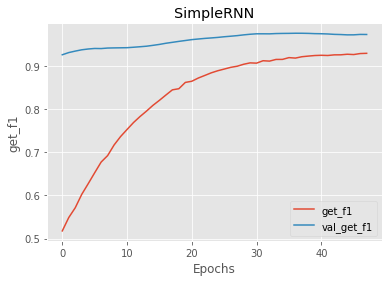

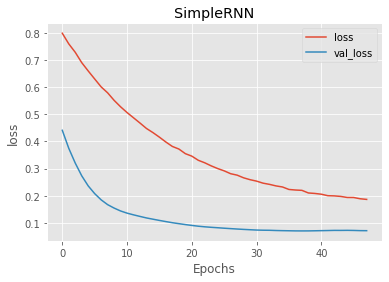

In [125]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title('SimpleRNN')
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/MA/rnn/rnn_ate.png')

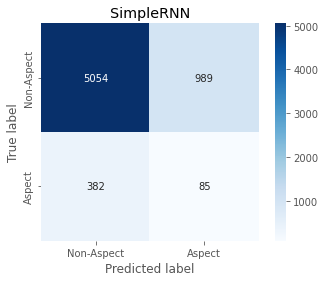

In [126]:
cm = confusion_matrix(final_y, final_p)

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('SimpleRNN')
plt.show()

### GRU

In [127]:

input = Input(shape=(maxlen,),dtype="int32")
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
model = GRU(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # previously softmax output layer



In [128]:
model = Model(input,out)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 207)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 207, 300)          593400    
                                                                 
 gru (GRU)                   (None, 207, 600)          1623600   
                                                                 
 time_distributed_2 (TimeDis  (None, 207, 2)           1202      
 tributed)                                                       
                                                                 
Total params: 2,218,202
Trainable params: 2,218,202
Non-trainable params: 0
_________________________________________________________________


In [129]:
adam = k.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [130]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 10, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [131]:
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=100, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6400 - get_f1: 0.6618
Epoch 1: val_loss improved from inf to 0.39483, saving model to /content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint/
2/2 [==============================] - 8s 5s/step - loss: 0.6400 - get_f1: 0.6618 - val_loss: 0.3948 - val_get_f1: 0.9861
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.3613 - get_f1: 0.9819
Epoch 2: val_loss improved from 0.39483 to 0.20155, saving model to /content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint/
2/2 [==============================] - 5s 5s/step - loss: 0.3613 - get_f1: 0.9819 - val_loss: 0.2015 - val_get_f1: 0.9892
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.1863 - get_f1: 0.9891
Epoch 3: val_loss improved from 0.20155 to 0.09544, saving model to /content/drive/MyDrive/Colab Notebooks/MA/gru/checkpoint/
2/2 [==============================] - 5s 4s/step - loss: 0.1863 - get_f1: 0.9891 - val_loss: 0.0954 - val_ge

In [132]:
p = model.predict(np.array(X_test)) 

7/7 [==============================] - 1s 73ms/step


In [133]:
#real len X_test
len_Xtest = []
for i in range(len(X_test)):
  j = X_test[i]
  j2 = [g for g in j if g != 1977]
  len_Xtest.append(len(j2))

print(len_Xtest)

#pred
final_p = []
for i, j in enumerate(len_Xtest):
  a = np.argmax(p, 2)
  a = a[i][:j].tolist()
  final_p.append(a)
final_p = sum(final_p, [])


#pred
final_y = []
for i, j in enumerate(len_Xtest):
  a = np.argmax(y_test, 2)
  a = a[i][:j].tolist()
  final_y.append(a)
final_y = sum(final_y, [])

[13, 68, 7, 28, 24, 16, 45, 16, 16, 40, 26, 37, 57, 12, 7, 52, 19, 31, 39, 19, 65, 20, 14, 19, 7, 49, 10, 196, 2, 22, 24, 19, 55, 54, 9, 46, 15, 25, 20, 42, 2, 17, 32, 9, 20, 5, 41, 43, 14, 16, 196, 18, 35, 207, 29, 38, 26, 19, 11, 16, 9, 21, 5, 3, 16, 5, 41, 18, 12, 28, 26, 14, 11, 16, 80, 28, 31, 18, 9, 23, 39, 6, 89, 20, 58, 2, 39, 5, 6, 8, 33, 38, 60, 30, 20, 33, 16, 41, 31, 32, 19, 41, 19, 24, 58, 52, 26, 50, 41, 36, 24, 26, 38, 8, 14, 23, 53, 37, 108, 16, 76, 48, 30, 58, 10, 20, 12, 17, 6, 21, 9, 25, 7, 31, 10, 29, 111, 6, 2, 25, 45, 91, 27, 4, 42, 43, 22, 25, 32, 2, 13, 63, 42, 23, 7, 6, 23, 37, 33, 7, 39, 17, 21, 45, 8, 9, 31, 39, 9, 37, 4, 4, 2, 52, 4, 23, 16, 7, 29, 40, 8, 5, 18, 50, 17, 12, 35, 32, 111, 9, 21, 19, 37, 35, 81, 11, 16, 12, 19, 21, 18, 30, 32, 22, 12, 9, 25, 141, 8, 29, 93, 5, 36, 3, 57, 24, 9]


In [134]:
print(classification_report(final_y, final_p,labels=list(idx2tag.keys())))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6043
           1       0.74      0.67      0.71       467

    accuracy                           0.96      6510
   macro avg       0.86      0.83      0.84      6510
weighted avg       0.96      0.96      0.96      6510



In [135]:
sum(np.argmax(p, axis=2).ravel())

422

In [136]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/gru/gru_ate.h5")

In [137]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/gru/gru_ate.h5",  custom_objects={"get_f1": get_f1})

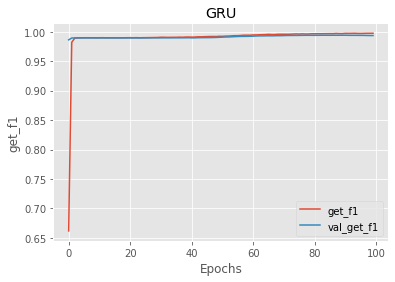

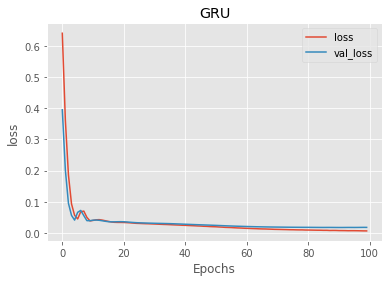

In [138]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title('GRU')
    plt.show()
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

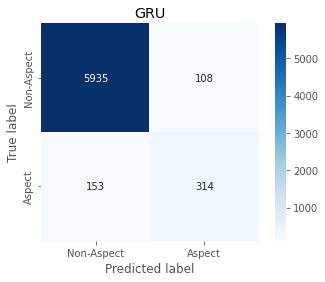

In [139]:
cm = confusion_matrix(final_y, final_p)

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('GRU')
plt.show()

### BiGRU


A Bidirectional GRU, or BiGRU, is a sequence processing model that consists of two GRUs. one taking the input in a forward direction, and the other in a backwards direction. It is a bidirectional recurrent neural network with only the input and forget gates.

In [140]:

input = Input(shape=(maxlen,),dtype="int32")
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
model = Bidirectional(GRU(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = GRU(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # previously softmax output layer



In [141]:
model = Model(input,out)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 207)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 207, 300)          593400    
                                                                 
 bidirectional (Bidirectiona  (None, 207, 600)         1083600   
 l)                                                              
                                                                 
 gru_2 (GRU)                 (None, 207, 600)          2163600   
                                                                 
 time_distributed_3 (TimeDis  (None, 207, 2)           1202      
 tributed)                                                       
                                                                 
Total params: 3,841,802
Trainable params: 3,841,802
Non-tra

In [142]:
adam = k.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [143]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 10, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [144]:
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=100, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.5103 - get_f1: 0.9132
Epoch 1: val_loss improved from inf to 0.13388, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint/
2/2 [==============================] - 24s 16s/step - loss: 0.5103 - get_f1: 0.9132 - val_loss: 0.1339 - val_get_f1: 0.9887
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.1255 - get_f1: 0.9858
Epoch 2: val_loss improved from 0.13388 to 0.06366, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint/
2/2 [==============================] - 17s 15s/step - loss: 0.1255 - get_f1: 0.9858 - val_loss: 0.0637 - val_get_f1: 0.9894
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.0660 - get_f1: 0.9895
Epoch 3: val_loss improved from 0.06366 to 0.04556, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bigru/checkpoint/
2/2 [==============================] - 16s 14s/step - loss: 0.0660 - get_f1: 0.9895 - val_loss: 0.0

In [145]:
p = model.predict(np.array(X_test)) 

7/7 [==============================] - 2s 218ms/step


In [146]:
#real len X_test
len_Xtest = []
for i in range(len(X_test)):
  j = X_test[i]
  j2 = [g for g in j if g != 1977]
  len_Xtest.append(len(j2))

print(len_Xtest)

#pred
final_p = []
for i, j in enumerate(len_Xtest):
  a = np.argmax(p, 2)
  a = a[i][:j].tolist()
  final_p.append(a)
final_p = sum(final_p, [])


#pred
final_y = []
for i, j in enumerate(len_Xtest):
  a = np.argmax(y_test, 2)
  a = a[i][:j].tolist()
  final_y.append(a)
final_y = sum(final_y, [])

[13, 68, 7, 28, 24, 16, 45, 16, 16, 40, 26, 37, 57, 12, 7, 52, 19, 31, 39, 19, 65, 20, 14, 19, 7, 49, 10, 196, 2, 22, 24, 19, 55, 54, 9, 46, 15, 25, 20, 42, 2, 17, 32, 9, 20, 5, 41, 43, 14, 16, 196, 18, 35, 207, 29, 38, 26, 19, 11, 16, 9, 21, 5, 3, 16, 5, 41, 18, 12, 28, 26, 14, 11, 16, 80, 28, 31, 18, 9, 23, 39, 6, 89, 20, 58, 2, 39, 5, 6, 8, 33, 38, 60, 30, 20, 33, 16, 41, 31, 32, 19, 41, 19, 24, 58, 52, 26, 50, 41, 36, 24, 26, 38, 8, 14, 23, 53, 37, 108, 16, 76, 48, 30, 58, 10, 20, 12, 17, 6, 21, 9, 25, 7, 31, 10, 29, 111, 6, 2, 25, 45, 91, 27, 4, 42, 43, 22, 25, 32, 2, 13, 63, 42, 23, 7, 6, 23, 37, 33, 7, 39, 17, 21, 45, 8, 9, 31, 39, 9, 37, 4, 4, 2, 52, 4, 23, 16, 7, 29, 40, 8, 5, 18, 50, 17, 12, 35, 32, 111, 9, 21, 19, 37, 35, 81, 11, 16, 12, 19, 21, 18, 30, 32, 22, 12, 9, 25, 141, 8, 29, 93, 5, 36, 3, 57, 24, 9]


In [147]:
print(classification_report(final_y, final_p,labels=list(idx2tag.keys())))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6043
           1       0.77      0.66      0.71       467

    accuracy                           0.96      6510
   macro avg       0.87      0.82      0.85      6510
weighted avg       0.96      0.96      0.96      6510



In [148]:
sum(np.argmax(p, axis=2).ravel())

404

In [149]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/bigru/bigru_ate.h5")

In [150]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bigru/bigru_ate.h5",  custom_objects={"get_f1": get_f1})

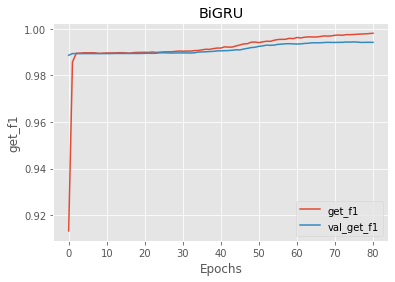

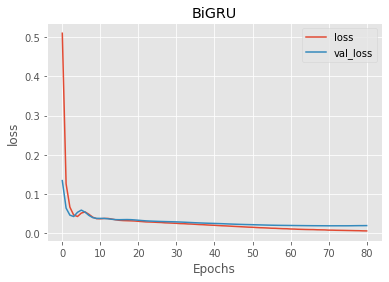

In [151]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title('BiGRU')
    plt.show()
    
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

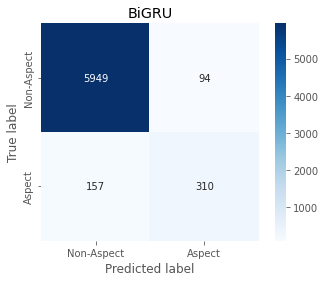

In [152]:
cm = confusion_matrix(final_y, final_p)

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('BiGRU')
plt.show()

### LSTM

In [153]:

input = Input(shape=(maxlen,),dtype="int32")
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)

model = LSTM(units=word_embedding_size*2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # previously softmax output layer



In [154]:
model = Model(input,out)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 207)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 207, 300)          593400    
                                                                 
 lstm (LSTM)                 (None, 207, 600)          2162400   
                                                                 
 time_distributed_4 (TimeDis  (None, 207, 2)           1202      
 tributed)                                                       
                                                                 
Total params: 2,757,002
Trainable params: 2,757,002
Non-trainable params: 0
_________________________________________________________________


In [155]:
adam = k.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [156]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 10, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [157]:
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=100, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.5147 - get_f1: 0.9573
Epoch 1: val_loss improved from inf to 0.22111, saving model to /content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint/
2/2 [==============================] - 8s 5s/step - loss: 0.5147 - get_f1: 0.9573 - val_loss: 0.2211 - val_get_f1: 0.9871
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.1922 - get_f1: 0.9850
Epoch 2: val_loss improved from 0.22111 to 0.08151, saving model to /content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint/
2/2 [==============================] - 5s 4s/step - loss: 0.1922 - get_f1: 0.9850 - val_loss: 0.0815 - val_get_f1: 0.9893
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.0804 - get_f1: 0.9892
Epoch 3: val_loss improved from 0.08151 to 0.06106, saving model to /content/drive/MyDrive/Colab Notebooks/MA/lstm/checkpoint/
2/2 [==============================] - 5s 4s/step - loss: 0.0804 - get_f1: 0.9892 - val_loss: 0.0611 - val

In [158]:
p = model.predict(np.array(X_test)) 

7/7 [==============================] - 1s 79ms/step


In [159]:
#real len X_test
len_Xtest = []
for i in range(len(X_test)):
  j = X_test[i]
  j2 = [g for g in j if g != 1977]
  len_Xtest.append(len(j2))

print(len_Xtest)

#pred
final_p = []
for i, j in enumerate(len_Xtest):
  a = np.argmax(p, 2)
  a = a[i][:j].tolist()
  final_p.append(a)
final_p = sum(final_p, [])


#pred
final_y = []
for i, j in enumerate(len_Xtest):
  a = np.argmax(y_test, 2)
  a = a[i][:j].tolist()
  final_y.append(a)
final_y = sum(final_y, [])

[13, 68, 7, 28, 24, 16, 45, 16, 16, 40, 26, 37, 57, 12, 7, 52, 19, 31, 39, 19, 65, 20, 14, 19, 7, 49, 10, 196, 2, 22, 24, 19, 55, 54, 9, 46, 15, 25, 20, 42, 2, 17, 32, 9, 20, 5, 41, 43, 14, 16, 196, 18, 35, 207, 29, 38, 26, 19, 11, 16, 9, 21, 5, 3, 16, 5, 41, 18, 12, 28, 26, 14, 11, 16, 80, 28, 31, 18, 9, 23, 39, 6, 89, 20, 58, 2, 39, 5, 6, 8, 33, 38, 60, 30, 20, 33, 16, 41, 31, 32, 19, 41, 19, 24, 58, 52, 26, 50, 41, 36, 24, 26, 38, 8, 14, 23, 53, 37, 108, 16, 76, 48, 30, 58, 10, 20, 12, 17, 6, 21, 9, 25, 7, 31, 10, 29, 111, 6, 2, 25, 45, 91, 27, 4, 42, 43, 22, 25, 32, 2, 13, 63, 42, 23, 7, 6, 23, 37, 33, 7, 39, 17, 21, 45, 8, 9, 31, 39, 9, 37, 4, 4, 2, 52, 4, 23, 16, 7, 29, 40, 8, 5, 18, 50, 17, 12, 35, 32, 111, 9, 21, 19, 37, 35, 81, 11, 16, 12, 19, 21, 18, 30, 32, 22, 12, 9, 25, 141, 8, 29, 93, 5, 36, 3, 57, 24, 9]


In [160]:
print(classification_report(final_y, final_p,labels=list(idx2tag.keys())))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      6043
           1       0.70      0.51      0.59       467

    accuracy                           0.95      6510
   macro avg       0.83      0.75      0.78      6510
weighted avg       0.94      0.95      0.95      6510



In [161]:
sum(np.argmax(p, axis=2).ravel())

339

In [162]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/lstm/lstm_ate.h5")

In [163]:
a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/lstm/lstm_ate.h5",  custom_objects={"get_f1": get_f1})

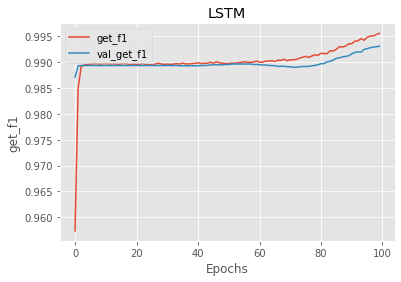

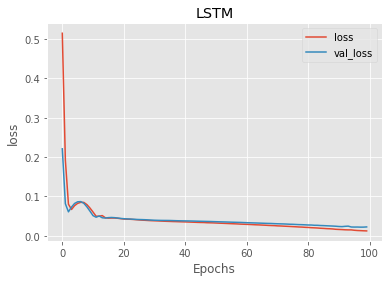

In [164]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title('LSTM')
    plt.show()
    
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

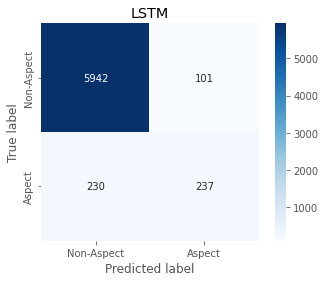

In [165]:
cm = confusion_matrix(final_y, final_p)

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('LSTM')
plt.show()

### Bi-LSTM

In [166]:

input = Input(shape=(maxlen,),dtype="int32")
word_embedding_size = 300
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)
model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # previously softmax output layer



In [167]:
model = Model(input,out)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 207)]             0         
                                                                 
 embedding_5 (Embedding)     (None, 207, 300)          593400    
                                                                 
 bidirectional_1 (Bidirectio  (None, 207, 600)         1442400   
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 207, 600)          2882400   
                                                                 
 time_distributed_5 (TimeDis  (None, 207, 2)           1202      
 tributed)                                                       
                                                                 
Total params: 4,919,402
Trainable params: 4,919,402
Non-tra

In [168]:

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [169]:
adam = k.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=[get_f1])

In [170]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 10, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

In [171]:
#class_weights

In [172]:
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=100, validation_split=0.2, verbose=1, callbacks=callbacks_list)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 0.6067 - get_f1: 0.5186
Epoch 1: val_loss improved from inf to 0.11730, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint/
2/2 [==============================] - 24s 14s/step - loss: 0.6067 - get_f1: 0.5186 - val_loss: 0.1173 - val_get_f1: 0.9893
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 0.1121 - get_f1: 0.9885
Epoch 2: val_loss improved from 0.11730 to 0.05803, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint/
2/2 [==============================] - 15s 13s/step - loss: 0.1121 - get_f1: 0.9885 - val_loss: 0.0580 - val_get_f1: 0.9894
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 0.0575 - get_f1: 0.9896
Epoch 3: val_loss improved from 0.05803 to 0.05163, saving model to /content/drive/MyDrive/Colab Notebooks/MA/bilstm/checkpoint/
2/2 [==============================] - 17s 14s/step - loss: 0.0575 - get_f1: 0.9896 - val_loss: 

In [173]:
p = model.predict(np.array(X_test)) 

7/7 [==============================] - 2s 202ms/step


In [174]:
#real len X_test
len_Xtest = []
for i in range(len(X_test)):
  j = X_test[i]
  j2 = [g for g in j if g != 1977]
  len_Xtest.append(len(j2))

print(len_Xtest)

#pred
final_p = []
for i, j in enumerate(len_Xtest):
  a = np.argmax(p, 2)
  a = a[i][:j].tolist()
  final_p.append(a)
final_p = sum(final_p, [])


#pred
final_y = []
for i, j in enumerate(len_Xtest):
  a = np.argmax(y_test, 2)
  a = a[i][:j].tolist()
  final_y.append(a)
final_y = sum(final_y, [])

[13, 68, 7, 28, 24, 16, 45, 16, 16, 40, 26, 37, 57, 12, 7, 52, 19, 31, 39, 19, 65, 20, 14, 19, 7, 49, 10, 196, 2, 22, 24, 19, 55, 54, 9, 46, 15, 25, 20, 42, 2, 17, 32, 9, 20, 5, 41, 43, 14, 16, 196, 18, 35, 207, 29, 38, 26, 19, 11, 16, 9, 21, 5, 3, 16, 5, 41, 18, 12, 28, 26, 14, 11, 16, 80, 28, 31, 18, 9, 23, 39, 6, 89, 20, 58, 2, 39, 5, 6, 8, 33, 38, 60, 30, 20, 33, 16, 41, 31, 32, 19, 41, 19, 24, 58, 52, 26, 50, 41, 36, 24, 26, 38, 8, 14, 23, 53, 37, 108, 16, 76, 48, 30, 58, 10, 20, 12, 17, 6, 21, 9, 25, 7, 31, 10, 29, 111, 6, 2, 25, 45, 91, 27, 4, 42, 43, 22, 25, 32, 2, 13, 63, 42, 23, 7, 6, 23, 37, 33, 7, 39, 17, 21, 45, 8, 9, 31, 39, 9, 37, 4, 4, 2, 52, 4, 23, 16, 7, 29, 40, 8, 5, 18, 50, 17, 12, 35, 32, 111, 9, 21, 19, 37, 35, 81, 11, 16, 12, 19, 21, 18, 30, 32, 22, 12, 9, 25, 141, 8, 29, 93, 5, 36, 3, 57, 24, 9]


In [175]:
print(classification_report(final_y, final_p,labels=list(idx2tag.keys())))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      6043
           1       0.75      0.65      0.70       467

    accuracy                           0.96      6510
   macro avg       0.86      0.82      0.84      6510
weighted avg       0.96      0.96      0.96      6510



In [176]:
X_train.shape

(505, 207)

In [177]:
np.argmax(p, axis=2).ravel()

array([0, 0, 0, ..., 0, 0, 0])

In [178]:
sum(np.argmax(p, axis=2).ravel())

407

In [179]:
#488

In [180]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/bilstm/bilstm_ate.h5")

In [181]:

a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bilstm/bilstm_ate.h5",  custom_objects={"get_f1": get_f1})

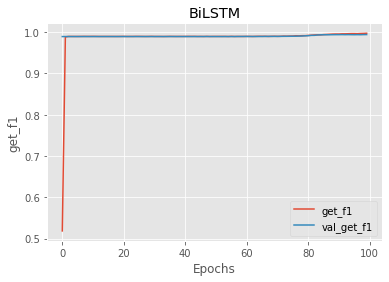

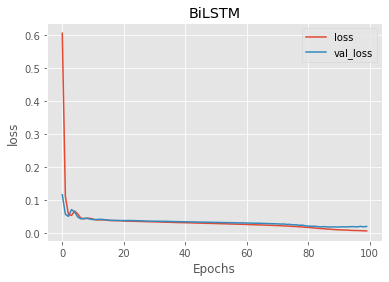

In [182]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title('BiLSTM')
    plt.show()
    
plot_graphs(history, 'get_f1')
plot_graphs(history, 'loss')

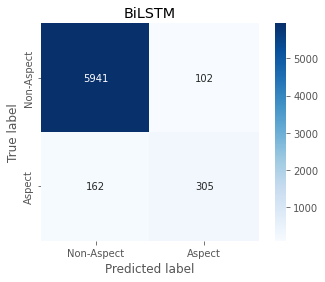

In [183]:
cm = confusion_matrix(final_y, final_p)

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('BiLSTM')
plt.show()

## Transfomers

### BERT

In [169]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [170]:
df_dl = pd.concat([train,test])
df_dl = df_dl[['id','lemma','pos_','flag']]
dataset = df_dl.rename(columns={"id": "sentence_idx", "lemma": "word","pos_":"pos","flag":"tag"})
dataset['tag'] = dataset['tag'].replace(0.0, 'None')
dataset['tag'] = dataset['tag'].replace(1.0, 'Aspect')

In [171]:
dataset.head()

,sentence_idx,word,pos,tag
0,142122,make,VERB,None
1,142122,waffle,NOUN,Aspect
2,142122,to,ADP,None
3,142122,the,DET,None
4,142122,recipe,NOUN,Aspect


In [172]:
dataset["sentence_idx"] = dataset["sentence_idx"].fillna(method="ffill")
sentence = dataset.groupby("sentence_idx")["word"].apply(list).values
pos = dataset.groupby(by = 'sentence_idx')['pos'].apply(list).values
tag = dataset.groupby(by = 'sentence_idx')['tag'].apply(list).values

In [173]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = maxlen
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')
                        
        
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

In [174]:
def process_data(data_path):
    df = data_path
    df.loc[:, "sentence_idx"] = df["sentence_idx"].fillna(method="ffill")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "pos"] = enc_pos.fit_transform(df["pos"])
    df.loc[:, "tag"] = enc_tag.fit_transform(df["tag"])

    sentences = df.groupby("sentence_idx")["word"].apply(list).values
    pos = df.groupby("sentence_idx")["pos"].apply(list).values
    tag = df.groupby("sentence_idx")["tag"].apply(list).values
    return sentences, pos, tag, enc_pos, enc_tag

sentence,pos,tag,enc_pos,enc_tag = process_data(dataset)

The bare Bert Model transformer outputting raw hidden-states without any specific head on top.

In [175]:
X_train,X_test,y_train,y_test = train_test_split(sentence,tag,random_state=29,test_size=0.3)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((505,), (217,), (505,), (217,))

In [176]:
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)

100%|██████████| 505/505 [00:00<00:00, 3613.55it/s]


In [177]:
input_ids.shape

(505, 207)

In [178]:
val_input_ids,val_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 217/217 [00:00<00:00, 3741.79it/s]


In [179]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

{207}

In [180]:
# Train Padding with 2
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (maxlen-len(y_test[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{207}

In [181]:
# Train Padding with 2
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (maxlen-len(y_train[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{207}

In [182]:

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(n_tags,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

'''#Connecting to GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

In [183]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
model = create_model(bert_model,MAX_LEN)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [184]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 207)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 207)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_5[0][0]',                
                                thPoolingAndCrossAt               'input_6[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 207,                                         

In [185]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 10, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

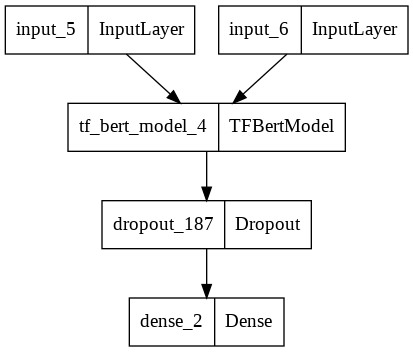

In [186]:
tf.keras.utils.plot_model(model)

In [187]:
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(test_tag)),epochs = 50,batch_size = 30,callbacks = callbacks_list,verbose = 1, validation_split=0.1)

Epoch 1/50


17/17 [==============================] - ETA: 0s - loss: 0.2436 - accuracy: 0.9027
Epoch 1: val_loss improved from inf to 0.08012, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 106s 5s/step - loss: 0.2436 - accuracy: 0.9027 - val_loss: 0.0801 - val_accuracy: 0.9726
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.0763 - accuracy: 0.9733
Epoch 2: val_loss improved from 0.08012 to 0.05768, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 81s 5s/step - loss: 0.0763 - accuracy: 0.9733 - val_loss: 0.0577 - val_accuracy: 0.9802
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9778
Epoch 3: val_loss improved from 0.05768 to 0.05421, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 85s 5s/step - loss: 0.0626 - accuracy: 0.9778 - val_loss: 0.0542 - val_accuracy: 0.9815
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9799
Epoch 4: val_loss improved from 0.05421 to 0.04872, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 81s 5s/step - loss: 0.0575 - accuracy: 0.9799 - val_loss: 0.0487 - val_accuracy: 0.9824
Epoch 5/50
17/17 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9813
Epoch 5: val_loss improved from 0.04872 to 0.04655, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 83s 5s/step - loss: 0.0522 - accuracy: 0.9813 - val_loss: 0.0466 - val_accuracy: 0.9841
Epoch 6/50
17/17 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9826
Epoch 6: val_loss improved from 0.04655 to 0.04465, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 82s 5s/step - loss: 0.0494 - accuracy: 0.9826 - val_loss: 0.0447 - val_accuracy: 0.9849
Epoch 7/50
17/17 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9837
Epoch 7: val_loss improved from 0.04465 to 0.04347, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 82s 5s/step - loss: 0.0467 - accuracy: 0.9837 - val_loss: 0.0435 - val_accuracy: 0.9851
Epoch 8/50
17/17 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9846
Epoch 8: val_loss improved from 0.04347 to 0.04282, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 84s 5s/step - loss: 0.0446 - accuracy: 0.9846 - val_loss: 0.0428 - val_accuracy: 0.9855
Epoch 9/50
17/17 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9850
Epoch 9: val_loss improved from 0.04282 to 0.04197, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 82s 5s/step - loss: 0.0427 - accuracy: 0.9850 - val_loss: 0.0420 - val_accuracy: 0.9858
Epoch 10/50
17/17 [==============================] - ETA: 0s - loss: 0.0411 - accuracy: 0.9859
Epoch 10: val_loss improved from 0.04197 to 0.04113, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 85s 5s/step - loss: 0.0411 - accuracy: 0.9859 - val_loss: 0.0411 - val_accuracy: 0.9860
Epoch 11/50
17/17 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9864
Epoch 11: val_loss improved from 0.04113 to 0.04037, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 82s 5s/step - loss: 0.0395 - accuracy: 0.9864 - val_loss: 0.0404 - val_accuracy: 0.9863
Epoch 12/50
17/17 [==============================] - ETA: 0s - loss: 0.0374 - accuracy: 0.9867
Epoch 12: val_loss improved from 0.04037 to 0.04001, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 85s 5s/step - loss: 0.0374 - accuracy: 0.9867 - val_loss: 0.0400 - val_accuracy: 0.9866
Epoch 13/50
17/17 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9874
Epoch 13: val_loss did not improve from 0.04001
17/17 [==============================] - 24s 1s/step - loss: 0.0362 - accuracy: 0.9874 - val_loss: 0.0405 - val_accuracy: 0.9866
Epoch 14/50
17/17 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9881
Epoch 14: val_loss improved from 0.04001 to 0.03906, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 85s 5s/step - loss: 0.0349 - accuracy: 0.9881 - val_loss: 0.0391 - val_accuracy: 0.9871
Epoch 15/50
17/17 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9883
Epoch 15: val_loss improved from 0.03906 to 0.03878, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 81s 5s/step - loss: 0.0342 - accuracy: 0.9883 - val_loss: 0.0388 - val_accuracy: 0.9872
Epoch 16/50
17/17 [==============================] - ETA: 0s - loss: 0.0332 - accuracy: 0.9888
Epoch 16: val_loss improved from 0.03878 to 0.03831, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 85s 5s/step - loss: 0.0332 - accuracy: 0.9888 - val_loss: 0.0383 - val_accuracy: 0.9874
Epoch 17/50
17/17 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9894
Epoch 17: val_loss improved from 0.03831 to 0.03789, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


17/17 [==============================] - 81s 5s/step - loss: 0.0311 - accuracy: 0.9894 - val_loss: 0.0379 - val_accuracy: 0.9876
Epoch 18/50
17/17 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9899
Epoch 18: val_loss did not improve from 0.03789
17/17 [==============================] - 24s 1s/step - loss: 0.0294 - accuracy: 0.9899 - val_loss: 0.0390 - val_accuracy: 0.9877
Epoch 19/50
17/17 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0.9903
Epoch 19: val_loss did not improve from 0.03789
17/17 [==============================] - 26s 2s/step - loss: 0.0283 - accuracy: 0.9903 - val_loss: 0.0395 - val_accuracy: 0.9873
Epoch 20/50
17/17 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9901
Epoch 20: val_loss did not improve from 0.03789
17/17 [==============================] - 25s 1s/step - loss: 0.0278 - accuracy: 0.9901 - val_loss: 0.0387 - val_accuracy: 0.9876
Epoch 21/50
17/17 [==============================] - ET

Epoch 31: val_loss did not improve from 0.03722
17/17 [==============================] - 25s 2s/step - loss: 0.0166 - accuracy: 0.9936 - val_loss: 0.0409 - val_accuracy: 0.9874
Epoch 31: early stopping

In [188]:
 model.predict([val_input_ids,val_attention_mask])

7/7 [==============================] - 6s 445ms/step


array([[[5.3218249e-02, 9.4678169e-01],
        [1.0415805e-01, 8.9584190e-01],
        [7.6165229e-01, 2.3834775e-01],
        ...,
        [9.9999523e-01, 4.7243384e-06],
        [9.9999619e-01, 3.8485564e-06],
        [9.9999630e-01, 3.6571191e-06]],

       [[5.3465515e-03, 9.9465346e-01],
        [2.3883495e-01, 7.6116502e-01],
        [1.5410814e-02, 9.8458916e-01],
        ...,
        [9.9998236e-01, 1.7679207e-05],
        [9.9999130e-01, 8.7536973e-06],
        [9.9999332e-01, 6.6582629e-06]],

       [[6.0605342e-03, 9.9393952e-01],
        [1.0062888e-02, 9.8993707e-01],
        [6.3548163e-02, 9.3645179e-01],
        ...,
        [9.9999404e-01, 6.0083917e-06],
        [9.9999380e-01, 6.1513151e-06],
        [9.9999225e-01, 7.7827017e-06]],

       ...,

       [[1.5009978e-03, 9.9849904e-01],
        [1.3503764e-02, 9.8649627e-01],
        [3.7434381e-02, 9.6256560e-01],
        ...,
        [9.9998951e-01, 1.0511724e-05],
        [9.9999344e-01, 6.5039562e-06],
        [

In [189]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_ate.h5")

In [190]:
a = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_ate.h5",  custom_objects={"TFBertModel": TFBertModel})

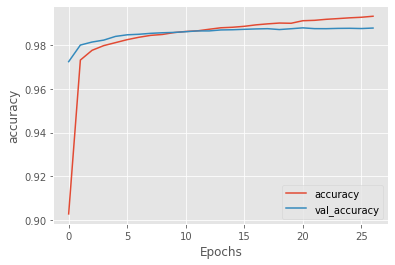

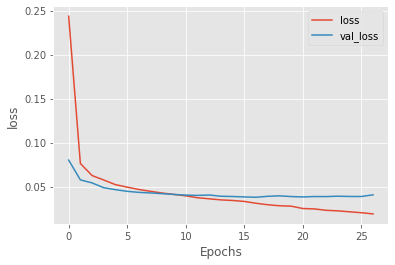

In [191]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history_bert, 'accuracy')
plot_graphs(history_bert, 'loss')

In [192]:
def pred(val_input_ids,val_attention_mask):
    return a.predict([val_input_ids,val_attention_mask])

In [193]:
def testing(val_input_ids,val_attention_mask,enc_tag,y_test):
    val_input = val_input_ids.reshape(1,maxlen)
    val_attention = val_attention_mask.reshape(1,maxlen)
    
    # Print Original Sentence
    sentence = tokenizer.decode(val_input_ids[val_input_ids > 0])
    #print("Original Text : ",str(sentence))
    #print("\n")
    true_enc_tag = enc_tag.inverse_transform(y_test)

    #print("Original Tags : " ,str(true_enc_tag))
    #print("\n")
    
    pred_with_pad = np.argmax(pred(val_input,val_attention),axis = -1) 
    pred_without_pad = pred_with_pad[pred_with_pad>-1]
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)
    pred_final = pred_enc_tag[0:len(true_enc_tag)]
    #print("Predicted Tags : ",pred_enc_tag[0:len(true_enc_tag)])
    return true_enc_tag, pred_final
  

In [194]:
testing(val_input_ids[2],val_attention_mask[2],enc_tag,y_test[2])

1/1 [==============================] - 3s 3s/step


(array(['None', 'None', 'None', 'None', 'Aspect', 'None', 'Aspect'],
       dtype=object),
 array(['None', 'None', 'None', 'None', 'Aspect', 'None', 'Aspect'],
       dtype=object))

In [195]:
results = []
for i in range(len(y_test)):
  result = testing(val_input_ids[i],val_attention_mask[i],enc_tag,y_test[i])
  results.append(result)

y_trues = []
for i in range(len(results)):
  y_true = results[i][0]
  y_trues.append(y_true)

y_preds = []
for i in range(len(results)):
  y_pred = results[i][1]
  y_preds.append(y_pred)


1/1 [==============================] - 0s 61ms/step


In [196]:
final = pd.DataFrame({"col1": np.concatenate(y_trues, axis=0),"col2": np.concatenate(y_preds, axis=0)})

In [197]:
print('accuracy')
print(accuracy_score(final.col1, final.col2))
print('f1 score')
print(f1_score(final.col1, final.col2,average=None))
print('recall')
print(recall_score(final.col1, final.col2,average=None))
print('precision')
print(precision_score(final.col1, final.col2,average=None))

accuracy
0.9302611367127496
f1 score
[0.3962766  0.96299315]
recall
[0.31905782 0.97749462]
precision
[0.52280702 0.94891566]


In [198]:
final[final.col2 =="Aspect"].shape[0]

285

In [199]:
print(classification_report(final.col1, final.col2))

              precision    recall  f1-score   support

      Aspect       0.52      0.32      0.40       467
        None       0.95      0.98      0.96      6043

    accuracy                           0.93      6510
   macro avg       0.74      0.65      0.68      6510
weighted avg       0.92      0.93      0.92      6510



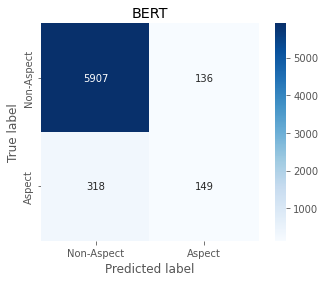

In [200]:
cm = confusion_matrix(final.col1, final.col2,labels=["None", "Aspect"])

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('BERT')
plt.show()

### BERT_main

26 mins

Run Train / test in Data Preprocessing

In [134]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [135]:
df_dl = pd.concat([train,test])
df_dl = df_dl[['id','lemma','pos_','flag']]
dataset = df_dl.rename(columns={"id": "sentence_idx", "lemma": "word","pos_":"pos","flag":"tag"})
dataset['tag'] = dataset['tag'].replace(0.0, 'None')
dataset['tag'] = dataset['tag'].replace(1.0, 'Aspect')

In [136]:
dataset.head()

,sentence_idx,word,pos,tag
0,142122,make,VERB,None
1,142122,waffle,NOUN,Aspect
2,142122,to,ADP,None
3,142122,the,DET,None
4,142122,recipe,NOUN,Aspect


In [137]:
dataset["sentence_idx"] = dataset["sentence_idx"].fillna(method="ffill")
sentence = dataset.groupby("sentence_idx")["word"].apply(list).values
pos = dataset.groupby(by = 'sentence_idx')['pos'].apply(list).values
tag = dataset.groupby(by = 'sentence_idx')['tag'].apply(list).values

In [138]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
MAX_LEN = maxlen
def tokenize(data,max_len = MAX_LEN):
    input_ids = list()
    attention_mask = list()
    for i in tqdm(range(len(data))):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens = True,
                                        max_length = MAX_LEN,
                                        is_split_into_words=True,
                                        return_attention_mask=True,
                                        padding = 'max_length',
                                        truncation=True,return_tensors = 'np')
                        
        
        input_ids.append(encoded['input_ids'])
        attention_mask.append(encoded['attention_mask'])
    return np.vstack(input_ids),np.vstack(attention_mask)

In [139]:
def process_data(data_path):
    df = data_path
    df.loc[:, "sentence_idx"] = df["sentence_idx"].fillna(method="ffill")

    enc_pos = preprocessing.LabelEncoder()
    enc_tag = preprocessing.LabelEncoder()

    df.loc[:, "pos"] = enc_pos.fit_transform(df["pos"])
    df.loc[:, "tag"] = enc_tag.fit_transform(df["tag"])

    sentences = df.groupby("sentence_idx")["word"].apply(list).values
    pos = df.groupby("sentence_idx")["pos"].apply(list).values
    tag = df.groupby("sentence_idx")["tag"].apply(list).values
    return sentences, pos, tag, enc_pos, enc_tag

sentence,pos,tag,enc_pos,enc_tag = process_data(dataset)

The bare Bert Model transformer outputting raw hidden-states without any specific head on top.

In [140]:
X_train,X_test,y_train,y_test = train_test_split(sentence,tag,random_state=29,test_size=0.3)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((505,), (217,), (505,), (217,))

In [141]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=29,test_size=0.2)

In [142]:
input_ids,attention_mask = tokenize(X_train,max_len = MAX_LEN)

100%|██████████| 404/404 [00:00<00:00, 3420.56it/s]


In [143]:
input_ids.shape

(404, 207)

In [144]:
val_input_ids,val_attention_mask = tokenize(X_val,max_len = MAX_LEN)

100%|██████████| 101/101 [00:00<00:00, 3973.59it/s]


In [145]:
test_input_ids,test_attention_mask = tokenize(X_test,max_len = MAX_LEN)

100%|██████████| 217/217 [00:00<00:00, 3417.01it/s]


In [146]:
# TEST: Checking Padding and Truncation length's
was = list()
for i in range(len(input_ids)):
    was.append(len(input_ids[i]))
set(was)

{207}

In [147]:
# Train Padding with 2
test_tag = list()
for i in range(len(y_test)):
    test_tag.append(np.array(y_test[i] + [0] * (maxlen-len(y_test[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(test_tag)):
    was.append(len(test_tag[i]))
set(was)

{207}

In [148]:
# Train Padding with 2
val_tag = list()
for i in range(len(y_val)):
    val_tag.append(np.array(y_val[i] + [0] * (maxlen-len(y_val[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(val_tag)):
    was.append(len(val_tag[i]))
set(was)

{207}

In [149]:
# Train Padding with 2
train_tag = list()
for i in range(len(y_train)):
    train_tag.append(np.array(y_train[i] + [0] * (maxlen-len(y_train[i]))))
    
# TEST:  Checking Padding Length
was = list()
for i in range(len(train_tag)):
    was.append(len(train_tag[i]))
set(was)

{207}

In [150]:

def create_model(bert_model,max_len = MAX_LEN):
    input_ids = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    attention_masks = tf.keras.Input(shape = (max_len,),dtype = 'int32')
    bert_output = bert_model(input_ids,attention_mask = attention_masks,return_dict =True)
    embedding = tf.keras.layers.Dropout(0.3)(bert_output["last_hidden_state"])
    output = tf.keras.layers.Dense(n_tags,activation = 'softmax')(embedding)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = [output])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    return model

'''#Connecting to GPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

In [151]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
model = create_model(bert_model,MAX_LEN)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [152]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 207)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 207)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 207,                                         

In [153]:
# Saving the best only

filepath="/content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/"
checkpoint = ModelCheckpoint(filepath,monitor='val_loss',mode='min',save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 10, verbose = 1,restore_best_weights = True)
callbacks_list = [earlystop, checkpoint]

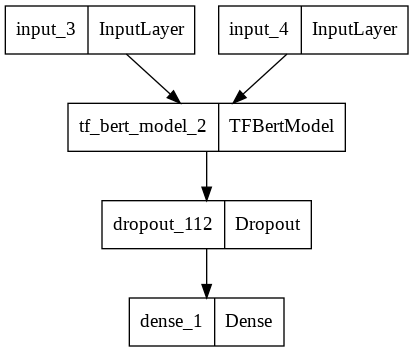

In [154]:
tf.keras.utils.plot_model(model)

In [155]:
history_bert = model.fit([input_ids,attention_mask],np.array(train_tag),validation_data = ([val_input_ids,val_attention_mask],np.array(val_tag)),epochs = 50,batch_size = 30,callbacks = callbacks_list,verbose = 1)

Epoch 1/50


14/14 [==============================] - ETA: 0s - loss: 0.3205 - accuracy: 0.8628
Epoch 1: val_loss improved from inf to 0.09132, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 102s 6s/step - loss: 0.3205 - accuracy: 0.8628 - val_loss: 0.0913 - val_accuracy: 0.9598
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.0945 - accuracy: 0.9680
Epoch 2: val_loss improved from 0.09132 to 0.06556, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 75s 6s/step - loss: 0.0945 - accuracy: 0.9680 - val_loss: 0.0656 - val_accuracy: 0.9802
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9742
Epoch 3: val_loss improved from 0.06556 to 0.05327, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 78s 6s/step - loss: 0.0710 - accuracy: 0.9742 - val_loss: 0.0533 - val_accuracy: 0.9812
Epoch 4/50
14/14 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9775
Epoch 4: val_loss improved from 0.05327 to 0.04986, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 75s 6s/step - loss: 0.0621 - accuracy: 0.9775 - val_loss: 0.0499 - val_accuracy: 0.9831
Epoch 5/50
14/14 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9798
Epoch 5: val_loss improved from 0.04986 to 0.04602, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 75s 6s/step - loss: 0.0572 - accuracy: 0.9798 - val_loss: 0.0460 - val_accuracy: 0.9838
Epoch 6/50
14/14 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9807
Epoch 6: val_loss improved from 0.04602 to 0.04405, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 78s 6s/step - loss: 0.0534 - accuracy: 0.9807 - val_loss: 0.0440 - val_accuracy: 0.9843
Epoch 7/50
14/14 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.9823
Epoch 7: val_loss improved from 0.04405 to 0.04251, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 76s 6s/step - loss: 0.0494 - accuracy: 0.9823 - val_loss: 0.0425 - val_accuracy: 0.9841
Epoch 8/50
14/14 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9833
Epoch 8: val_loss improved from 0.04251 to 0.04134, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 79s 6s/step - loss: 0.0472 - accuracy: 0.9833 - val_loss: 0.0413 - val_accuracy: 0.9850
Epoch 9/50
14/14 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9837
Epoch 9: val_loss improved from 0.04134 to 0.04059, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 76s 6s/step - loss: 0.0450 - accuracy: 0.9837 - val_loss: 0.0406 - val_accuracy: 0.9854
Epoch 10/50
14/14 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9845
Epoch 10: val_loss improved from 0.04059 to 0.03999, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 80s 6s/step - loss: 0.0446 - accuracy: 0.9845 - val_loss: 0.0400 - val_accuracy: 0.9857
Epoch 11/50
14/14 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9855
Epoch 11: val_loss improved from 0.03999 to 0.03941, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 75s 6s/step - loss: 0.0421 - accuracy: 0.9855 - val_loss: 0.0394 - val_accuracy: 0.9860
Epoch 12/50
14/14 [==============================] - ETA: 0s - loss: 0.0412 - accuracy: 0.9856
Epoch 12: val_loss improved from 0.03941 to 0.03903, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 78s 6s/step - loss: 0.0412 - accuracy: 0.9856 - val_loss: 0.0390 - val_accuracy: 0.9861
Epoch 13/50
14/14 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9863
Epoch 13: val_loss improved from 0.03903 to 0.03877, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 76s 6s/step - loss: 0.0392 - accuracy: 0.9863 - val_loss: 0.0388 - val_accuracy: 0.9863
Epoch 14/50
14/14 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9865
Epoch 14: val_loss improved from 0.03877 to 0.03867, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 78s 6s/step - loss: 0.0386 - accuracy: 0.9865 - val_loss: 0.0387 - val_accuracy: 0.9862
Epoch 15/50
14/14 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9871
Epoch 15: val_loss improved from 0.03867 to 0.03851, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 75s 6s/step - loss: 0.0367 - accuracy: 0.9871 - val_loss: 0.0385 - val_accuracy: 0.9864
Epoch 16/50
14/14 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9877
Epoch 16: val_loss improved from 0.03851 to 0.03820, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 77s 6s/step - loss: 0.0357 - accuracy: 0.9877 - val_loss: 0.0382 - val_accuracy: 0.9861
Epoch 17/50
14/14 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9885
Epoch 17: val_loss improved from 0.03820 to 0.03773, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 76s 6s/step - loss: 0.0334 - accuracy: 0.9885 - val_loss: 0.0377 - val_accuracy: 0.9860
Epoch 18/50
14/14 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9883
Epoch 18: val_loss did not improve from 0.03773
14/14 [==============================] - 18s 1s/step - loss: 0.0337 - accuracy: 0.9883 - val_loss: 0.0378 - val_accuracy: 0.9865
Epoch 19/50
14/14 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9890
Epoch 19: val_loss improved from 0.03773 to 0.03736, saving model to /content/drive/MyDrive/Colab Notebooks/MA/tfbert/checkpoint/


14/14 [==============================] - 76s 6s/step - loss: 0.0314 - accuracy: 0.9890 - val_loss: 0.0374 - val_accuracy: 0.9863
Epoch 20/50
14/14 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9895
Epoch 20: val_loss did not improve from 0.03736
14/14 [==============================] - 18s 1s/step - loss: 0.0304 - accuracy: 0.9895 - val_loss: 0.0378 - val_accuracy: 0.9861
Epoch 21/50
14/14 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9899
Epoch 21: val_loss did not improve from 0.03736
14/14 [==============================] - 19s 1s/step - loss: 0.0295 - accuracy: 0.9899 - val_loss: 0.0377 - val_accuracy: 0.9868
Epoch 22/50
14/14 [==============================] - ETA: 0s - loss: 0.0278 - accuracy: 0.9902
Epoch 22: val_loss did not improve from 0.03736
14/14 [==============================] - 20s 1s/step - loss: 0.0278 - accuracy: 0.9902 - val_loss: 0.0382 - val_accuracy: 0.9867
Epoch 23/50
14/14 [==============================] - ET

14/14 [==============================] - 78s 6s/step - loss: 0.0269 - accuracy: 0.9906 - val_loss: 0.0373 - val_accuracy: 0.9867
Epoch 24/50
14/14 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 0.9909
Epoch 24: val_loss did not improve from 0.03726
14/14 [==============================] - 19s 1s/step - loss: 0.0257 - accuracy: 0.9909 - val_loss: 0.0376 - val_accuracy: 0.9872
Epoch 25/50
14/14 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9915
Epoch 25: val_loss did not improve from 0.03726
14/14 [==============================] - 19s 1s/step - loss: 0.0248 - accuracy: 0.9915 - val_loss: 0.0380 - val_accuracy: 0.9873
Epoch 26/50
14/14 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.9917
Epoch 26: val_loss did not improve from 0.03726
14/14 [==============================] - 19s 1s/step - loss: 0.0236 - accuracy: 0.9917 - val_loss: 0.0381 - val_accuracy: 0.9867
Epoch 27/50
14/14 [==============================] - ET

Epoch 33: val_loss did not improve from 0.03726
14/14 [==============================] - 19s 1s/step - loss: 0.0156 - accuracy: 0.9945 - val_loss: 0.0429 - val_accuracy: 0.9871
Epoch 33: early stopping

In [ ]:
 model.predict([test_input_ids,test_attention_mask])

In [157]:
model.save("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_ate.h5")

In [158]:
a = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/MA/bert/bert_ate.h5",  custom_objects={"TFBertModel": TFBertModel})

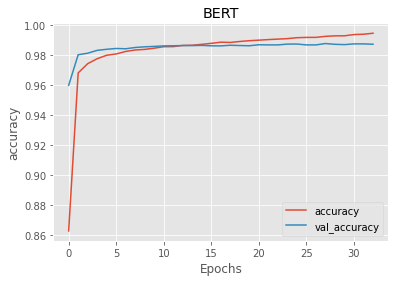

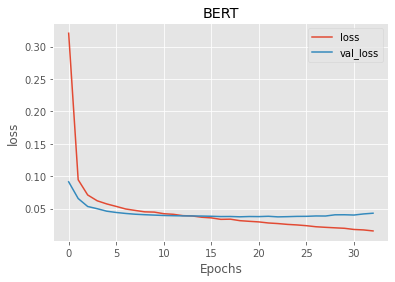

In [159]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.title('BERT')
    plt.show()
plot_graphs(history_bert, 'accuracy')
plot_graphs(history_bert, 'loss')

In [160]:
def pred(val_input_ids,val_attention_mask):
    return a.predict([val_input_ids,val_attention_mask])

In [161]:
def testing(val_input_ids,val_attention_mask,enc_tag,y_test):
    val_input = val_input_ids.reshape(1,maxlen)
    val_attention = val_attention_mask.reshape(1,maxlen)
    
    # Print Original Sentence
    sentence = tokenizer.decode(val_input_ids[val_input_ids > 0])
    #print("Original Text : ",str(sentence))
    #print("\n")
    true_enc_tag = enc_tag.inverse_transform(y_test)

    #print("Original Tags : " ,str(true_enc_tag))
    #print("\n")
    
    pred_with_pad = np.argmax(pred(val_input,val_attention),axis = -1) 
    pred_without_pad = pred_with_pad[pred_with_pad>-1]
    pred_enc_tag = enc_tag.inverse_transform(pred_without_pad)
    pred_final = pred_enc_tag[0:len(true_enc_tag)]
    #print("Predicted Tags : ",pred_enc_tag[0:len(true_enc_tag)])
    return true_enc_tag, pred_final
  

In [162]:
testing(test_input_ids[2],test_attention_mask[2],enc_tag,y_test[2])

1/1 [==============================] - 3s 3s/step


(array(['None', 'None', 'None', 'None', 'Aspect', 'None', 'Aspect'],
       dtype=object),
 array(['None', 'None', 'None', 'None', 'Aspect', 'None', 'None'],
       dtype=object))

In [163]:
results = []
for i in range(len(y_test)):
  result = testing(test_input_ids[i],test_attention_mask[i],enc_tag,y_test[i])
  results.append(result)

y_trues = []
for i in range(len(results)):
  y_true = results[i][0]
  y_trues.append(y_true)

y_preds = []
for i in range(len(results)):
  y_pred = results[i][1]
  y_preds.append(y_pred)


1/1 [==============================] - 0s 59ms/step


In [164]:
final = pd.DataFrame({"col1": np.concatenate(y_trues, axis=0),"col2": np.concatenate(y_preds, axis=0)})

In [165]:
print('accuracy')
print(accuracy_score(final.col1, final.col2))
print('f1 score')
print(f1_score(final.col1, final.col2,average=None))
print('recall')
print(recall_score(final.col1, final.col2,average=None))
print('precision')
print(precision_score(final.col1, final.col2,average=None))

accuracy
0.9218125960061444
f1 score
[0.37082818 0.95831627]
recall
[0.32119914 0.9682277 ]
precision
[0.43859649 0.94860571]


In [166]:
final[final.col2 =="Aspect"].shape[0]

342

In [167]:
print(classification_report(final.col1, final.col2))

              precision    recall  f1-score   support

      Aspect       0.44      0.32      0.37       467
        None       0.95      0.97      0.96      6043

    accuracy                           0.92      6510
   macro avg       0.69      0.64      0.66      6510
weighted avg       0.91      0.92      0.92      6510



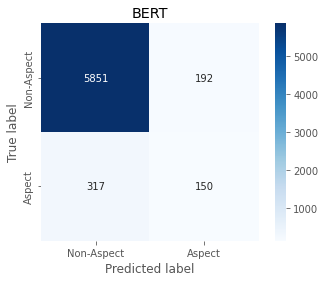

In [168]:
cm = confusion_matrix(final.col1, final.col2,labels=["None", "Aspect"])

x_axis_labels = ["Non-Aspect","Aspect"]
y_axis_labels = ["Non-Aspect","Aspect"]
ax = sns.heatmap(cm, xticklabels=x_axis_labels, yticklabels=y_axis_labels, annot=True, square=True, cmap=plt.cm.Blues,fmt='d')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('BERT')
plt.show()